In [1]:
import sys
sys.path.insert(1, '../src')
from util import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import warnings
from sklearn.decomposition import TruncatedSVD
from collections import defaultdict
from icecream import ic
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize;
from pandarallel import pandarallel
from IPython.display import clear_output
from wordcloud import WordCloud
import random
from PIL import Image
from itertools import chain
from collections import defaultdict

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", None)
pd.set_option("precision", 3)
%pylab inline
%config InlineBackend.figure_formats = ['retina']
pandarallel.initialize()

Populating the interactive namespace from numpy and matplotlib
INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
fn = '../data/data_preprocessed.pickle'
data = read_from_pickle(fn)
data.keys()

Read data from "../data/data_preprocessed.pickle"


dict_keys(['df_words_tkn', 'dict_ngrams', 'df_original'])

In [4]:
df_original = data['df_original']
df_words_tkn = data['df_words_tkn']
dict_ngrams = data['dict_ngrams']
remove_lst = ['mild traumatic brain', 'patient severe traumatic',
              'severe traumatic brain', 
              'injury traumatic brain', 'brain injury patient',
              'brain injury traumatic', 'traumatic brain injury',
              'central nervous system', 'patient traumatic brain',
              'mild traumatic brain injury', 'server traumatic brain injury'
              'year old',
             ]
for w in remove_lst:
    try:
        dict_ngrams['biigrams'].remove(w)
    except:
        print(w)

for w in remove_lst:
    try:
        dict_ngrams['trigrams'].remove(w)
    except:
        print(w)

for w in remove_lst:
    try:
        dict_ngrams['quagrams'].remove(w)
    except:
        print(w)

remove_lst = ['brain injury', 'traumatic brain', 'head injury',
              'mild traumatic', 'long term', 'severe traumatic',
              'post traumatic', 'patient traumatic', 'present study',
              'head trauma', 'injury traumatic', 'brain damage','brain barrier',
              'aim study', 'blood brain', 'scale score', 'systematic review',
              'quality life'
             ]
for w in remove_lst:
    try:
        dict_ngrams['bigrams'].remove(w)
    except:
        print(w)
    
exception_dict = ['day', 'month', 'hour', 'le', 'case', 'time',
                  'level', 'effect', 'data', 'change', 'analysis',
                  'test', 'result', 'brain injury rat', 'outcome', 'finding', 'condition',
                  'cost','muscle', 'artery','area', 'normal', 'role', 
                  'period', 'function', 'potential', 'region', 'use',
                  'type', 'min', 'different', 'approach', 'method',
                  'increase', 'decrease', 'reduce', 'low', 'site',
                  'max', 'mean', 'higher', 'lower', 'measure',
                  'total', 'activity','response', 'research',
                  'non', 'current', 'specific', 'week', 'new', 'old',
                  'task', 'work', 'evidence','management', 'common',
                  'health', 'number','analysis', 'study','bbb',
                  'aki', 'pre', 'bank', 'national', 'center', 'admission',
                  'dc', 'pc', 'il', 'administration', 'addition', 'value',
                  'early', 'greater', 'major', 'overall', 'related', 'single'
                  'participant', 'individual', 'key', 'self', 'ratio', 'kg',
                  'rate', 'cns', 'trauma', 'article', 'literature', 'available',
                  'range', 'comparison', 'purpose', 'systematic','review',
                  'search','medline','pubmed','embase','cochrane','meta',
                  'database','inclusion', 'limb', 'ml', 'life', 'support',
                  'caregiver', 'subject', 'evaluation', 'participant', 'quality',
                  'gene', 'problem', 'object', 'hand', 'odds', 'sci', 'activation',
                  'ad', 'disease', 'rare', 'baseline', 'item', 'male', 'female',
                  'persistent', 'procedure', 'older', 'service',
                  'performance', 'validity', 'status', 'mm', 'hg', 'person'
                 ]

mild traumatic brain
patient severe traumatic
severe traumatic brain
injury traumatic brain
brain injury patient
brain injury traumatic
traumatic brain injury
central nervous system
patient traumatic brain
mild traumatic brain injury
server traumatic brain injuryyear old
mild traumatic brain injury
server traumatic brain injuryyear old
mild traumatic brain
patient severe traumatic
severe traumatic brain
injury traumatic brain
brain injury patient
brain injury traumatic
traumatic brain injury
central nervous system
patient traumatic brain
server traumatic brain injuryyear old


In [5]:
df = pd.DataFrame()
df['year'] = df_original['year']
df['text'] = (df_original['title_and_abstract_lemma']
              .parallel_apply(word_tokenize)
              .parallel_apply(del_abbreviation)
              .parallel_apply(merge_ngrams,
                              dict_ngrams=dict_ngrams,
                              exception_dict=exception_dict)
              .parallel_apply(','.join)
             )



In [6]:
n_topics = 20
vectorizer = TfidfVectorizer(stop_words='english',
                             tokenizer=dummy, # dummy tokenizer to maintain phrases
                             analyzer='word',
                             min_df=2,
                             max_df=0.95,                                   
                            )
doc_word = vectorizer.fit_transform(df['text'])

nmf_model = NMF(n_components=n_topics,
                random_state=15,
                beta_loss='kullback-leibler',
                solver='mu', max_iter=2000,
                alpha=0.1, l1_ratio=0.5,
                init='nndsvd',
               )
doc_topics = nmf_model.fit_transform(doc_word);


In [7]:
doc_topics.shape
fn = '../data/doc_topics.pickle'
save_as_pickle(fn, doc_topics)

Saved data to "../data/doc_topics.pickle"


In [8]:
years = range(1991, 2022)
topic_words=defaultdict(list)
for y in years:
    words = vectorizer.get_feature_names()
    topic_word_yearly = nmf_model.components_.argsort(axis=1)[:,-1:-21:-1]
    topic_words = [[words[e] for e in l] for l in topic_word_yearly]
# topic_words    

In [9]:
topic_mat = nmf_model.components_
topic_mat.shape

(20, 31487)

In [10]:
def plot_top_words(model, feature_names,
                   n_top_words, no_docs,
                   figsize, topic_name):
    fig, axes = plt.subplots(5, 4, figsize=figsize, sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]

        ax.barh(top_features, weights, height=0.7)
        ax.set_title('{0}\n ({1} papers)'
                     .format(topic_name[topic_idx],
                             no_docs.values[no_docs.index[topic_idx]]),
                     fontdict={'fontsize': 25})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=25)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)

In [11]:
topic_name = ['Clinical study', 'Pathology or Injury mechanism', 'Pediatric study', 'Sport concussion',
              'Hospital mortality', 'Kinematic Study', 'Brain biomechanics', 'Military TBI',
              'Neuropsychological study', 'Blast injury', 'Post-conc. syndrome', 'Injury prediction',
              'Treatment or Therapy', 'Neuroimaging', 'TBI-relevant disease', 'Skull fracture or Hematoma',
              'Family func or social support', 'Intracranial pressure', 'Biomarkers', 'Animal study'
             ]

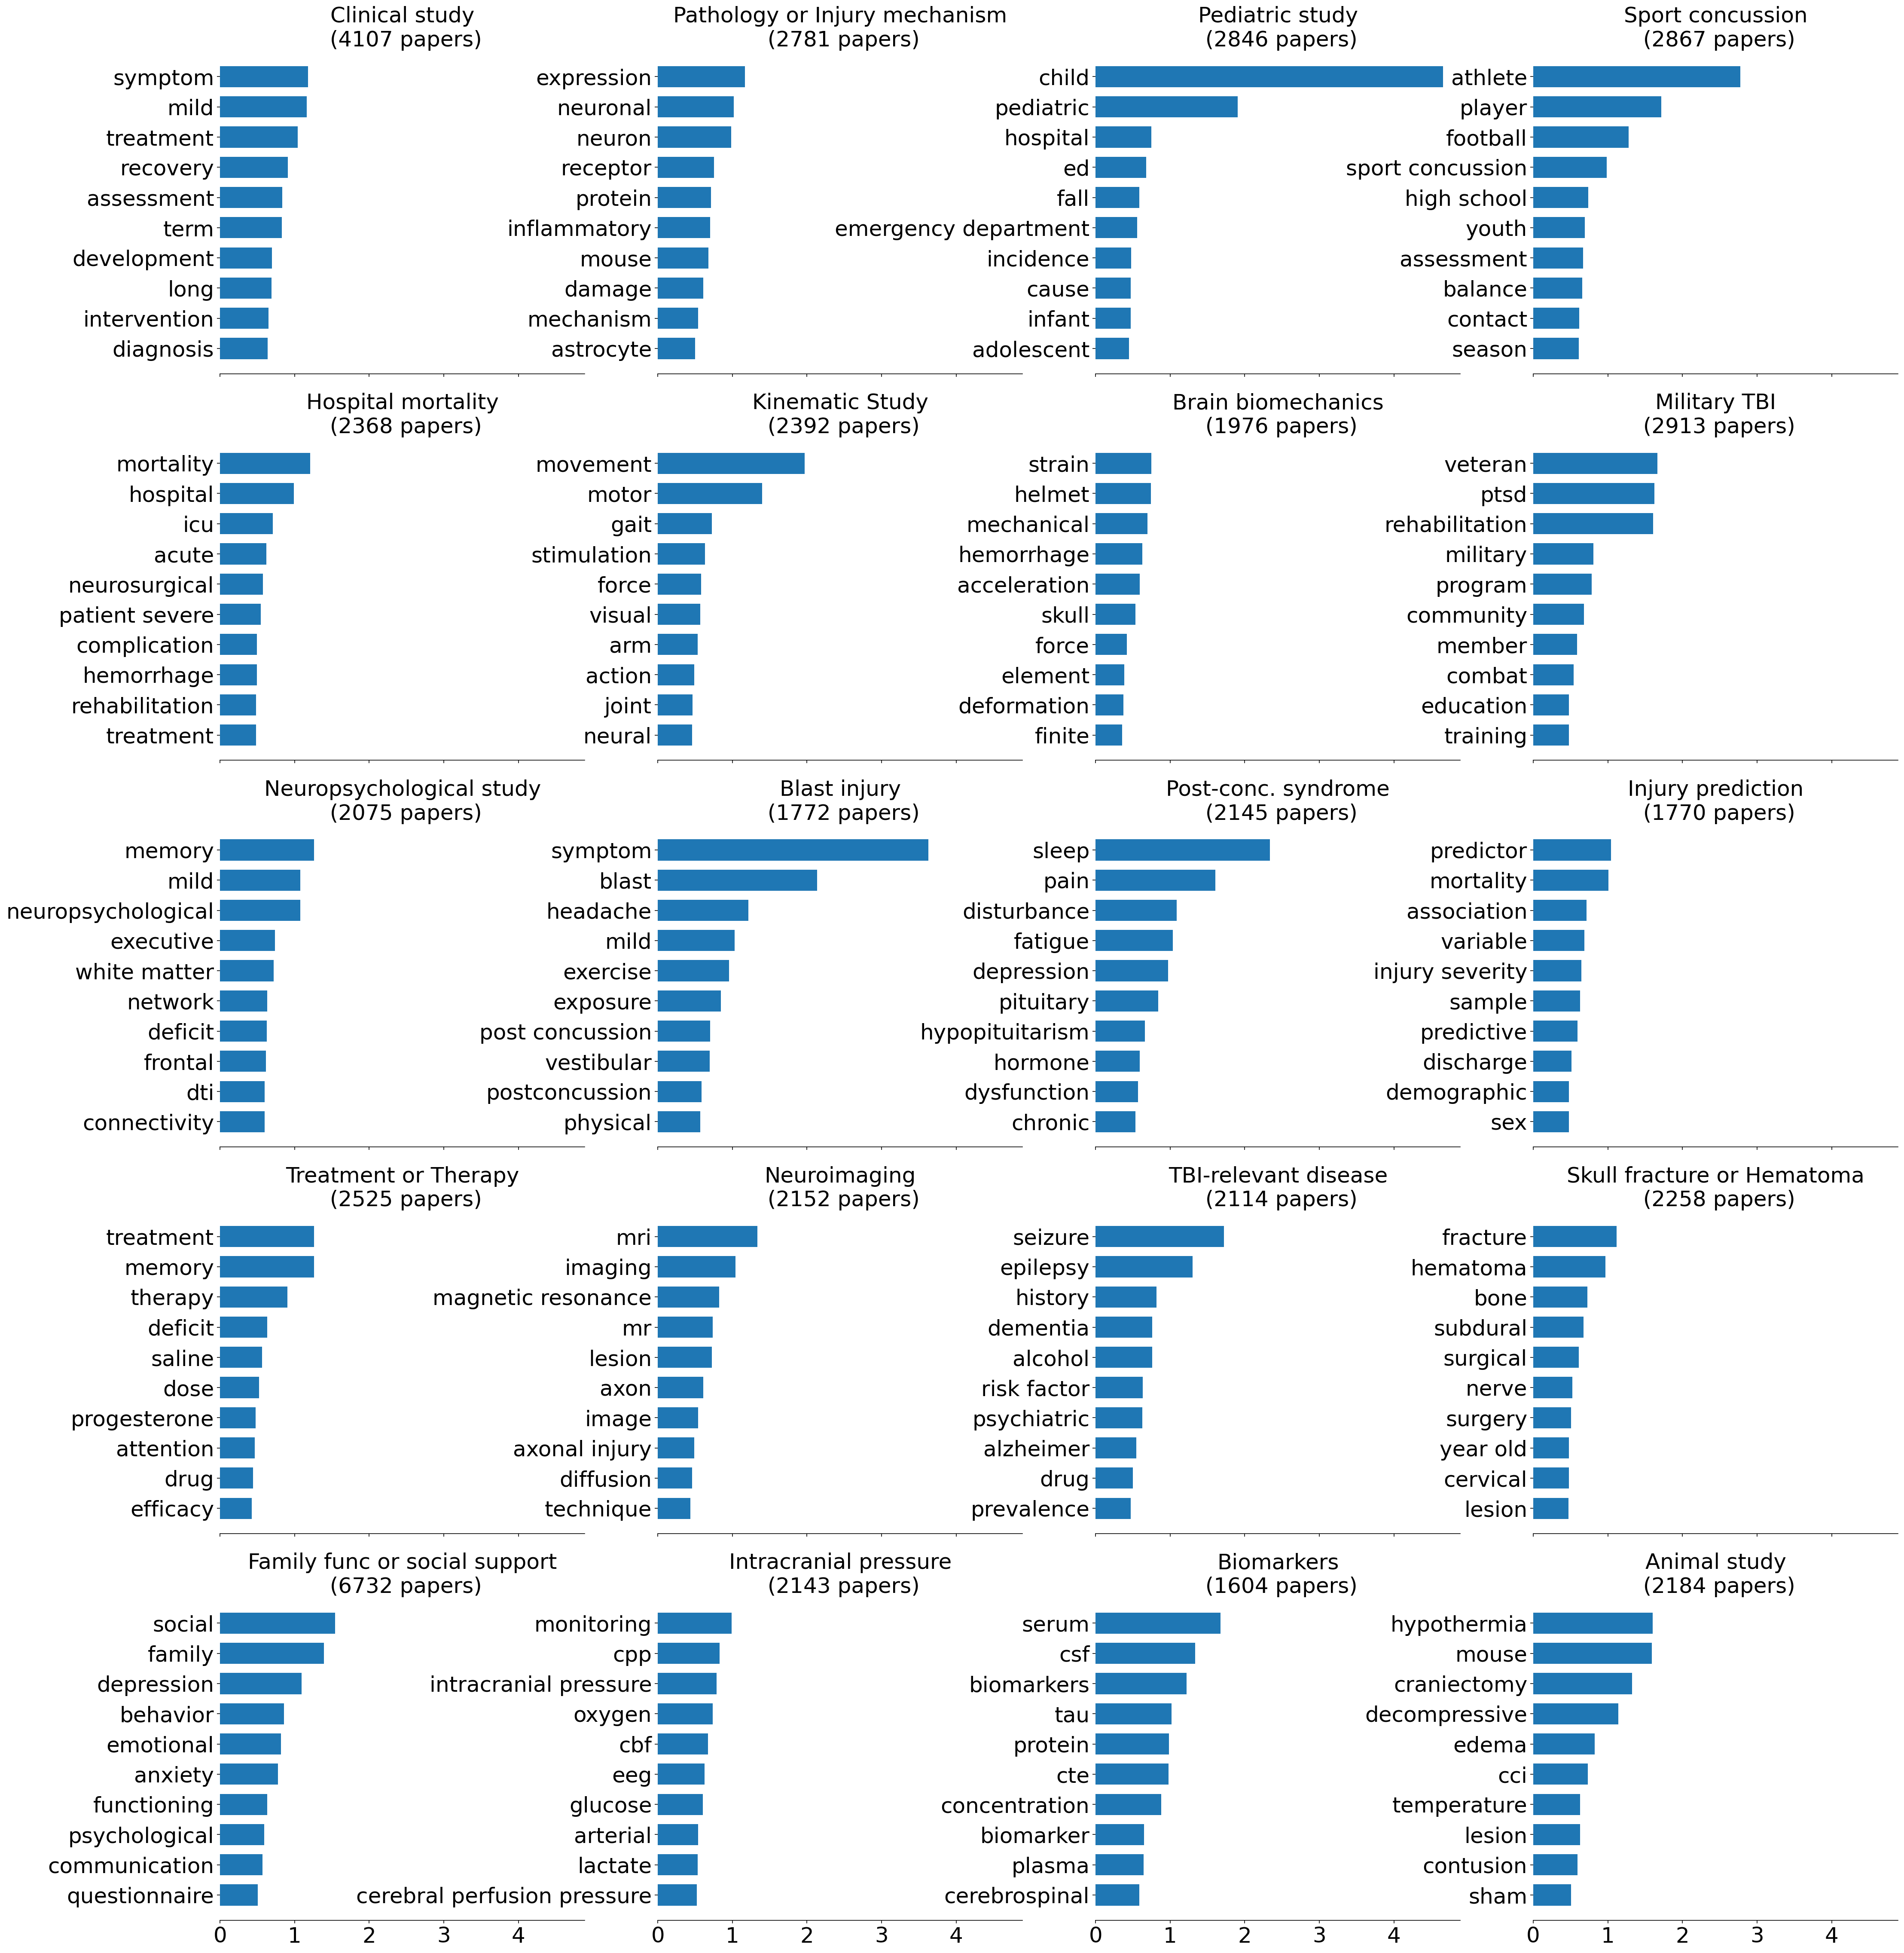

In [12]:
doc_cluster = doc_topics.argmax(axis = 1)
no_papers = pd.Series(doc_cluster).value_counts()

plot_top_words(nmf_model,
               vectorizer.get_feature_names(), 10, 
               no_papers,
               topic_name=topic_name,
               figsize=(35, 40))
fn = '../figures/all_topics_bargraph.png'.format(y)
plt.savefig(fn, dpi=300, bbox_inches='tight', facecolor="white")

In [13]:
# powerpoint front page
mask = np.array(Image.open('../figures/brain.jpg'))

w = list(chain.from_iterable(topic_words))
random.shuffle(w)

wc = WordCloud(background_color="white",
               random_state=20,
               width=500,
               height=500,
               mask=mask,
               contour_color='lightgray',               
              ).generate(','.join(w))

plt.subplots(figsize=(25
                      , 25));
plt.imshow(wc, interpolation='bilinear')
plt.axis("off");
fn = '../figures/front_page.svg'
plt.savefig(fn, dpi=300, bbox_inches='tight', facecolor="white")
plt.close()


In [14]:
yearly_counts_overall = df_original['year'].value_counts().sort_index().to_frame()
yearly_counts_overall.head(3)

,year
1991,199
1992,271
1993,267


In [15]:
df_original['topic_id'] = doc_topics.argmax(axis=1)
df_count = df_original[['topic_id', 'year', 'journal', 'title']]
res_count = df_count.groupby(by=['topic_id', 'year'], as_index=False).count()
res_count.drop(columns='title', inplace=True)
res_count = res_count.join(yearly_counts_overall, on='year', rsuffix='year')
res_count.columns = ['topic_id', 'year', 'counts_for_topic', 'yearly_counts']
res_count['norm_counts'] = 100*res_count['counts_for_topic']/res_count['yearly_counts']
res_count.head(10)

,topic_id,year,counts_for_topic,yearly_counts,norm_counts
0,0,1991,6,199,3.02
1,0,1992,15,271,5.54
2,0,1993,13,267,4.87
3,0,1994,11,346,3.18
4,0,1995,12,368,3.26
5,0,1996,22,446,4.93
6,0,1997,17,443,3.84
7,0,1998,17,534,3.18
8,0,1999,17,533,3.19
9,0,2000,26,684,3.80


In [16]:
# word cloud
for n in range(0, n_topics):
    wc = WordCloud(background_color="white",
                   random_state=15,
                   width=400,
                   height=300,
                  ).generate(','.join(topic_words[n]))
    plt.subplots(figsize=(6, 6));
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off");
    fn = '../figures/{}_wordcloud.svg'.format('_'.join(topic_name[n].split(' ')))
    plt.savefig(fn, dpi=300, bbox_inches='tight', facecolor="white")
    plt.close()


In [17]:
# # CV
# # evaluate parameters
# m = np.zeros([n_topics, len(years)])
# for n in range(0, n_topics):
#     m[n, :] = res_count['norm_counts'][res_count['topic_id'] == n]


# p_values = [0, 1, 2, 4, 6, 8, 10]
# d_values = range(0, 3)
# q_values = range(0, 3)

# best_cfg = defaultdict(list)
# best_score = defaultdict(list)
# for n in range(0, n_topics):
#         best_cfg[n], best_score[n] = evaluate_models(m[n,:],
#                                                      p_values, d_values, q_values,
#                                                      training_portion=0.66)

Best ARIMA(0, 0, 0) RMSE=0.410  
Best ARIMA(10, 1, 2) RMSE=1.052  
Best ARIMA(1, 2, 1) RMSE=0.532  
Best ARIMA(2, 2, 1) RMSE=1.096  
Best ARIMA(1, 1, 0) RMSE=0.920  
Best ARIMA(8, 2, 0) RMSE=0.990  
Best ARIMA(0, 0, 0) RMSE=0.569  
Best ARIMA(2, 1, 0) RMSE=0.698  
Best ARIMA(4, 2, 0) RMSE=0.465  
Best ARIMA(0, 2, 1) RMSE=0.397  
Best ARIMA(1, 0, 1) RMSE=0.662  
Best ARIMA(6, 0, 2) RMSE=0.439  
Best ARIMA(1, 2, 1) RMSE=0.529  
Best ARIMA(0, 0, 2) RMSE=0.360  
Best ARIMA(1, 1, 0) RMSE=0.353  
Best ARIMA(6, 1, 0) RMSE=0.268  
Best ARIMA(0, 1, 2) RMSE=0.468  
Best ARIMA(1, 1, 0) RMSE=0.850  
Best ARIMA(4, 2, 1) RMSE=0.440  
Best ARIMA(0, 1, 0) RMSE=0.458  

In [18]:
# fn = '../data/best_cfg.pickle'
# save_as_pickle(fn, best_cfg)
# fn = '../data/best_score.pickle'
# save_as_pickle(fn, best_score)

In [23]:
# forcasting 5 years
m = np.zeros([n_topics, len(years)])
for n in range(0, n_topics):
    m[n, :] = res_count['norm_counts'][res_count['topic_id'] == n]

fn = '../data/best_cfg.pickle'
best_cfg = read_from_pickle(fn)
forecast_year = 5
best_cfg[5] = (8, 1, 0) # not work with best param, better to use 1st order diff
forecast_dict = defaultdict(list)
for n in range(0, n_topics):
    order = best_cfg[n]
    mdl = ARIMA(m[n,:], order=order).fit()
    forecast_dict[n] = mdl.forecast(steps=forecast_year)

Read data from "../data/best_cfg.pickle"


In [21]:
mf = np.zeros([n_topics, forecast_year], )
for n in range(0, n_topics):
    mf[n, :] = forecast_dict[n][0]
m2 = np.concatenate((m, mf), axis=1)
years2 = np.arange(1991, 2027)
t_df = pd.DataFrame({'years': years2, 'norm_counts': m2[n, :]})
t_df['is_forcast'] = t_df['years'] > 2021
t_df.head()

,years,norm_counts,is_forcast
0,1991,3.52,False
1,1992,3.32,False
2,1993,4.12,False
3,1994,8.67,False
4,1995,6.25,False


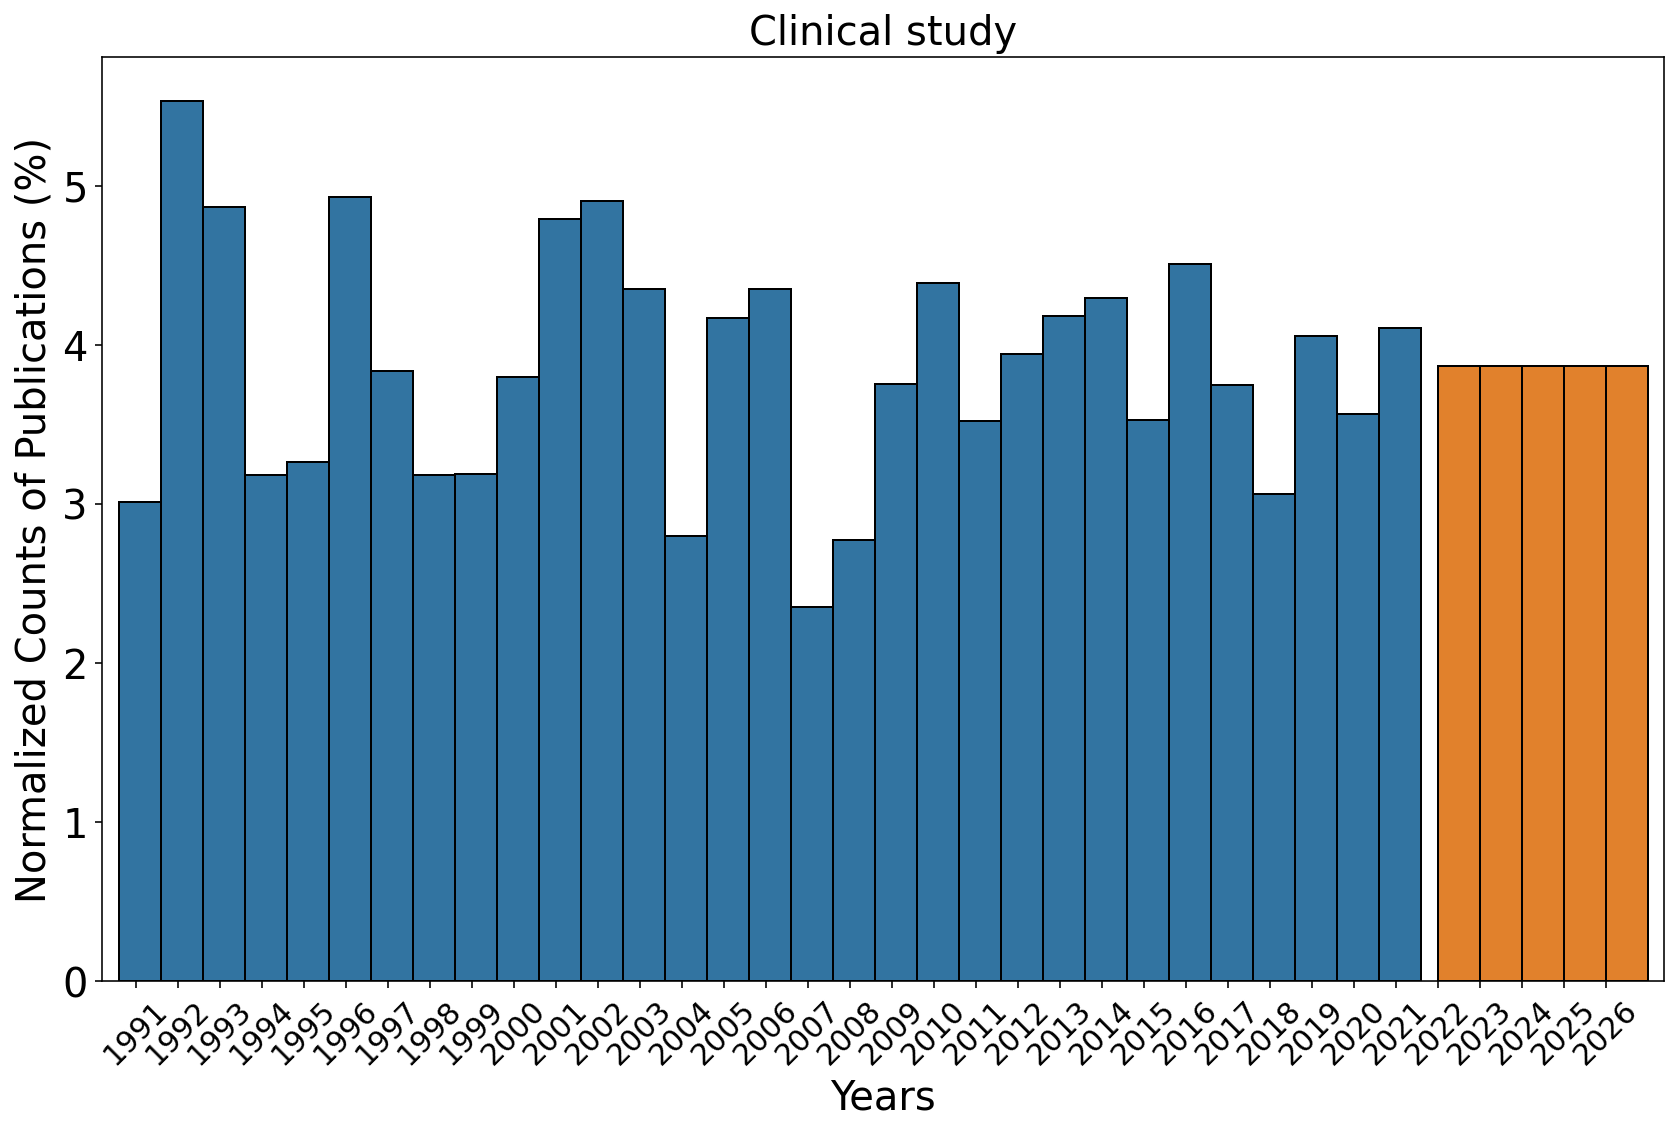

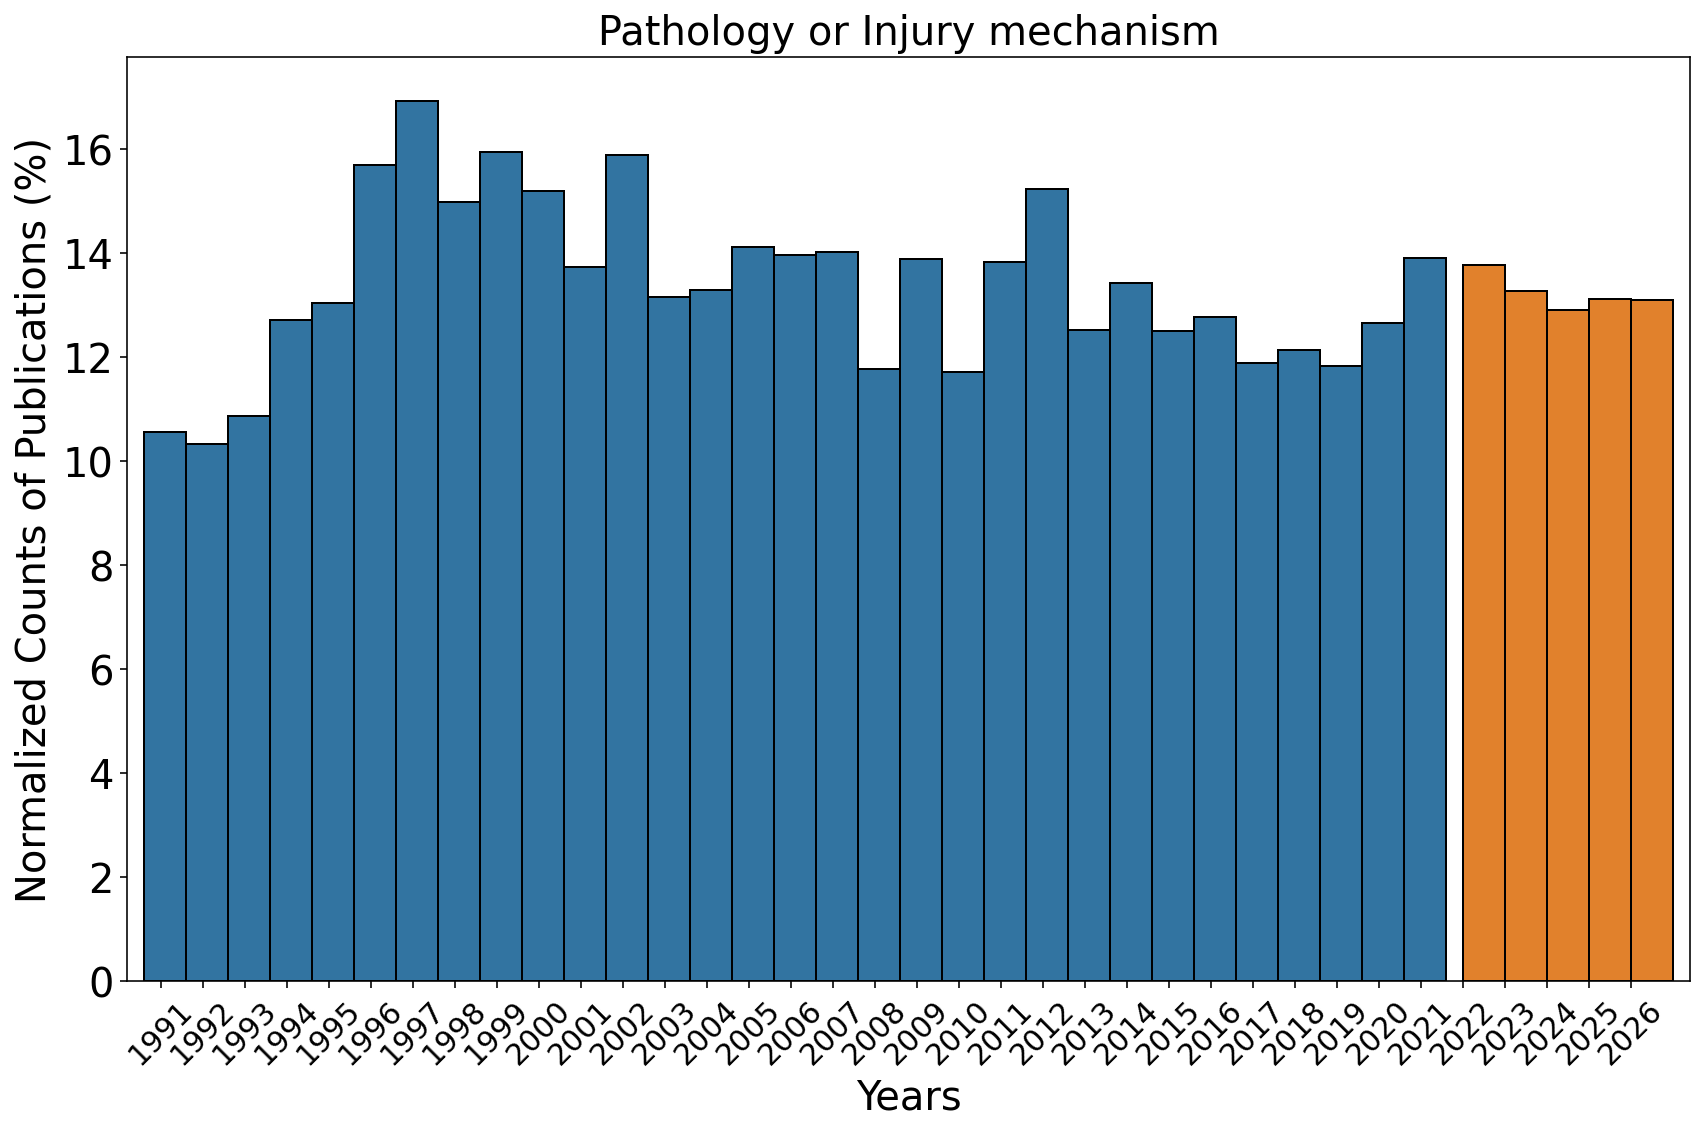

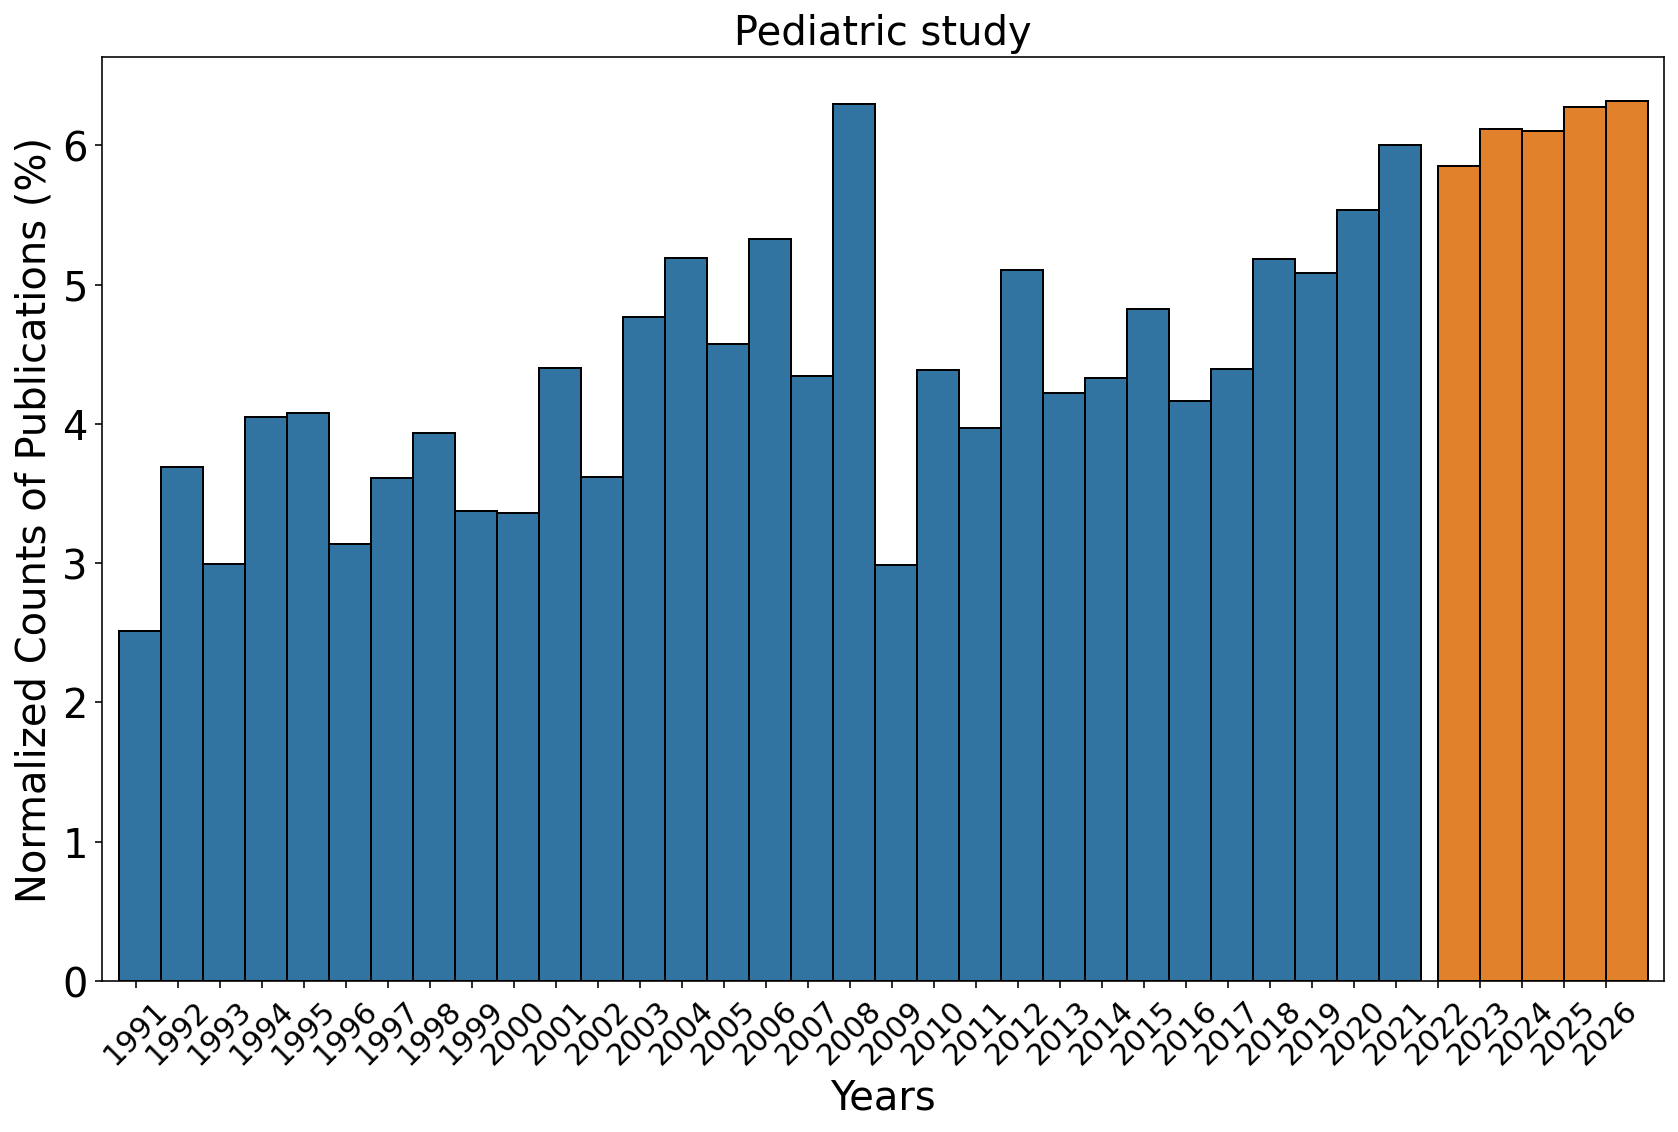

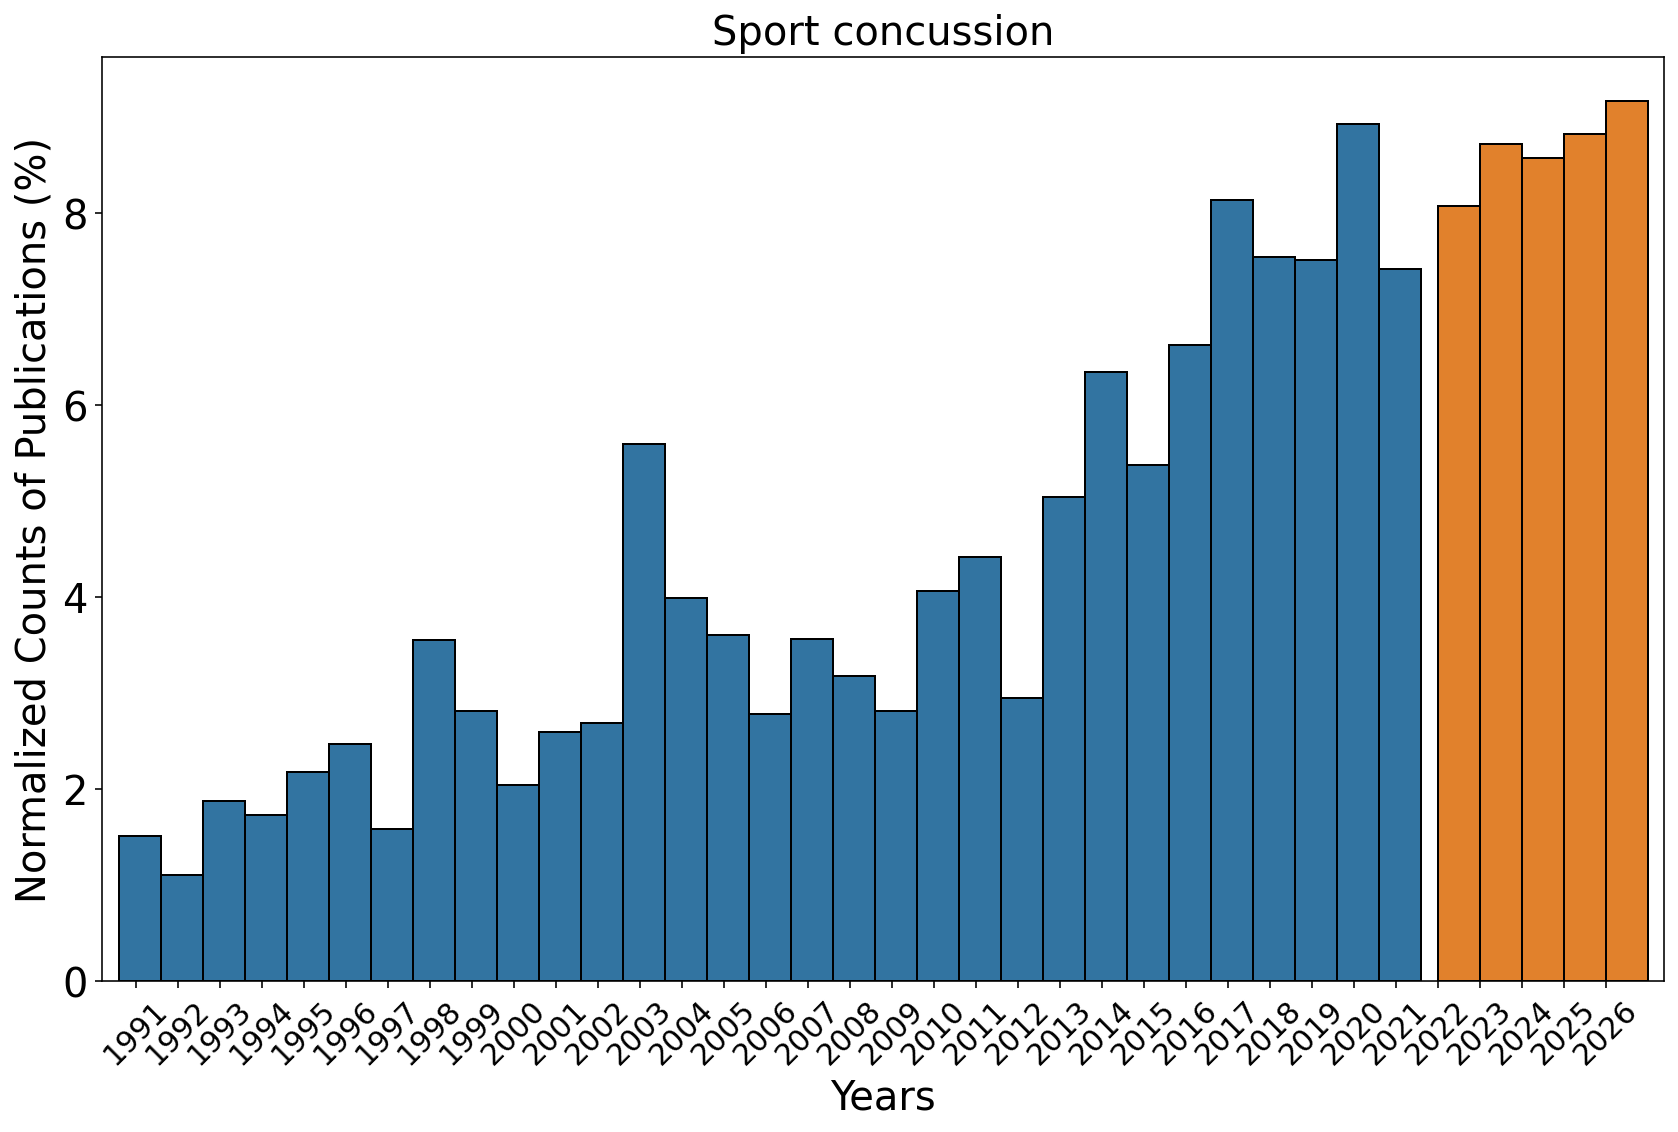

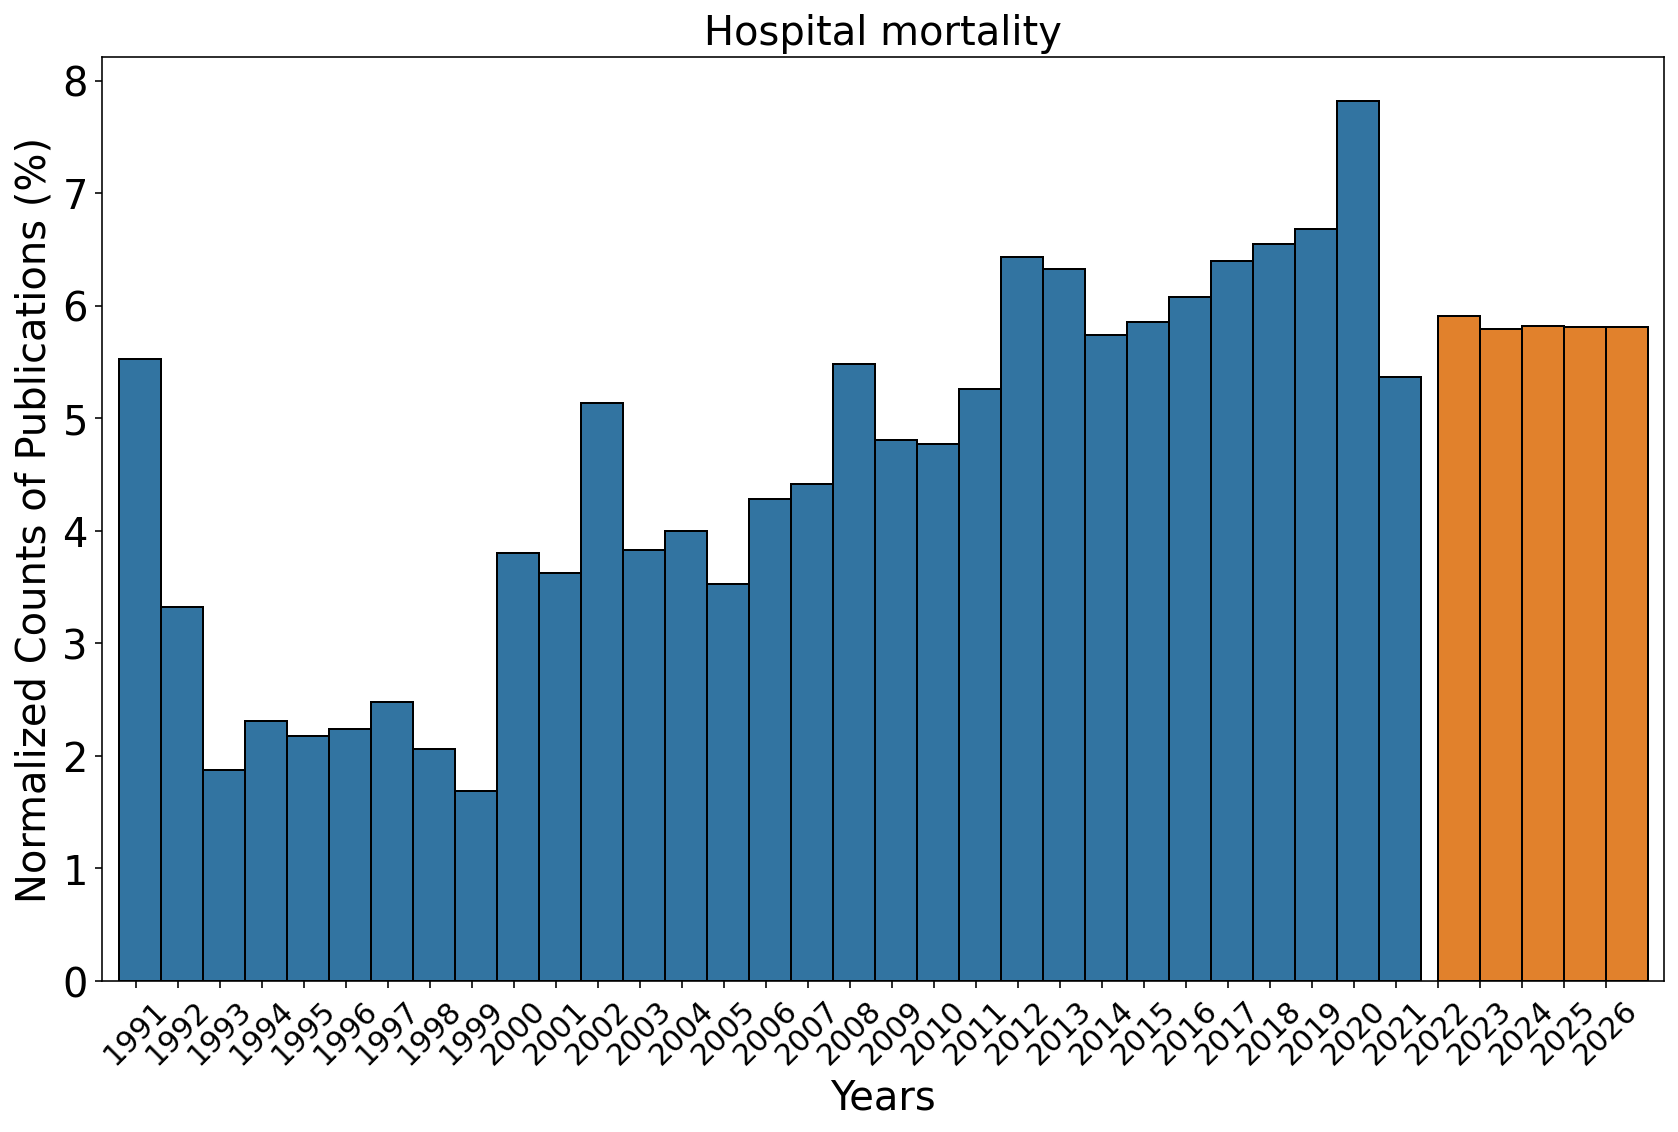

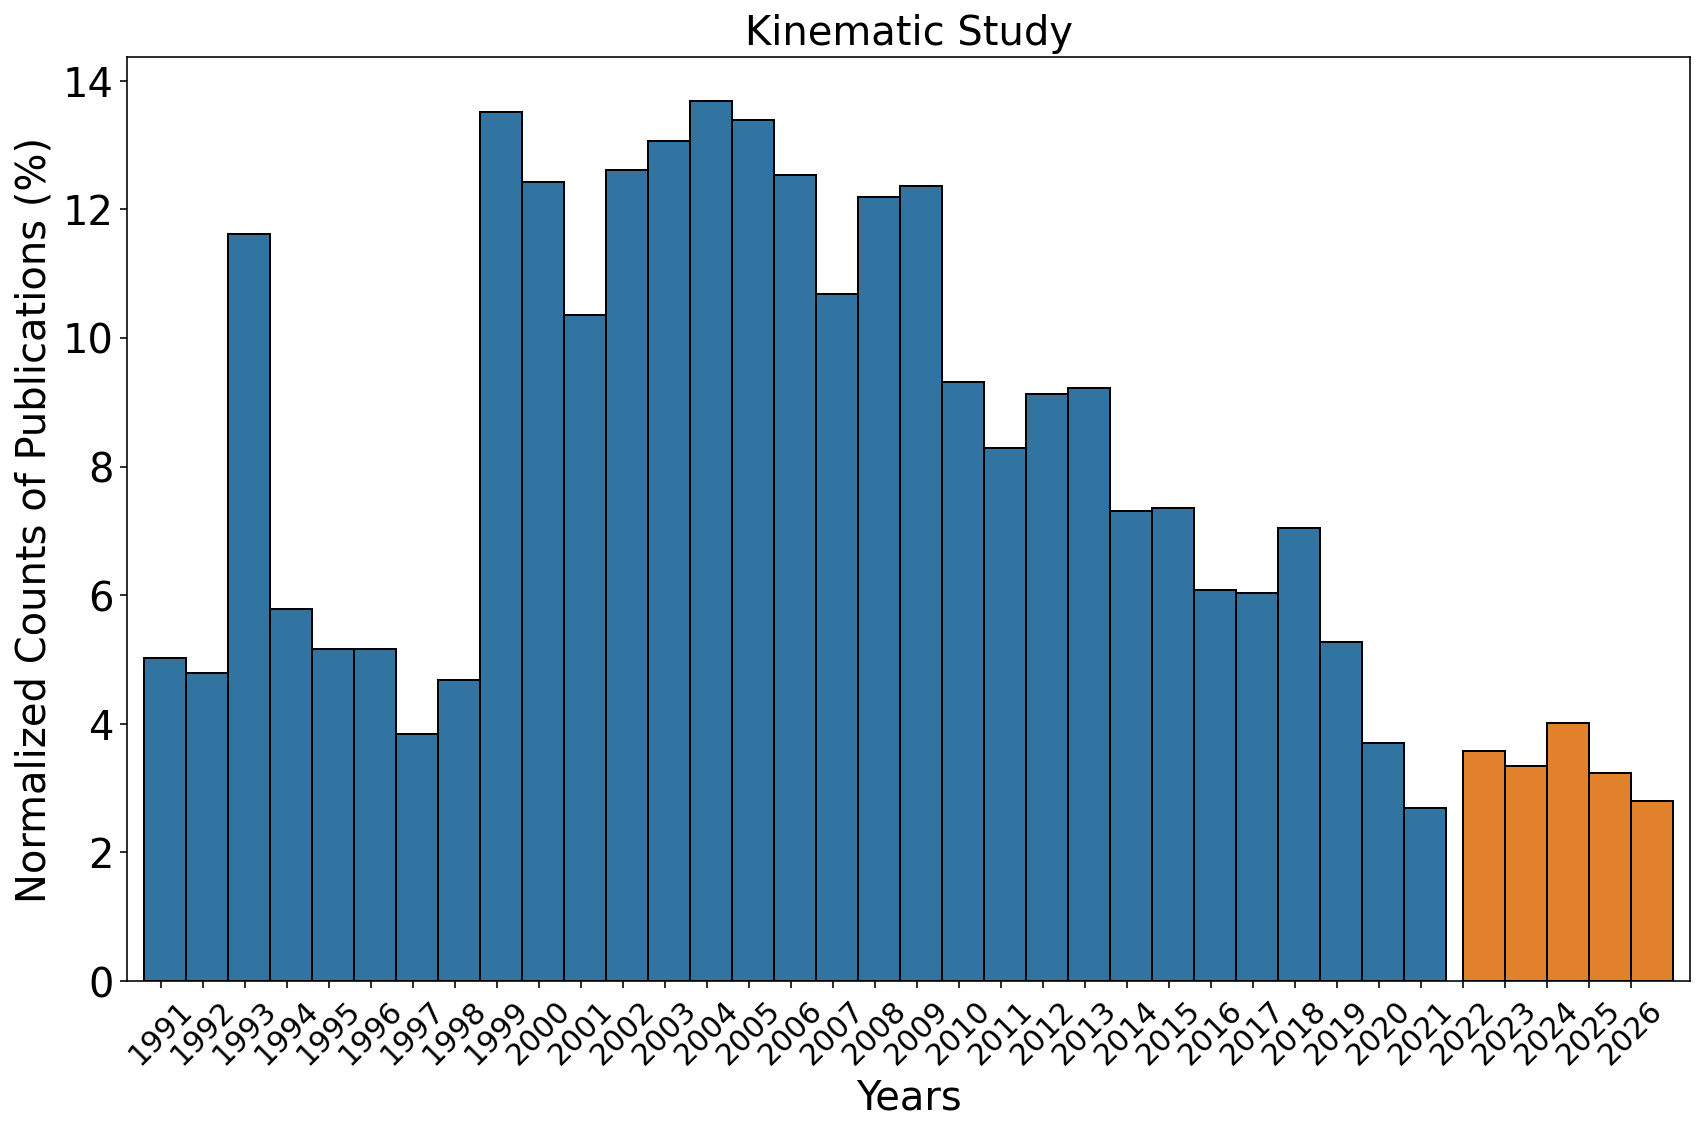

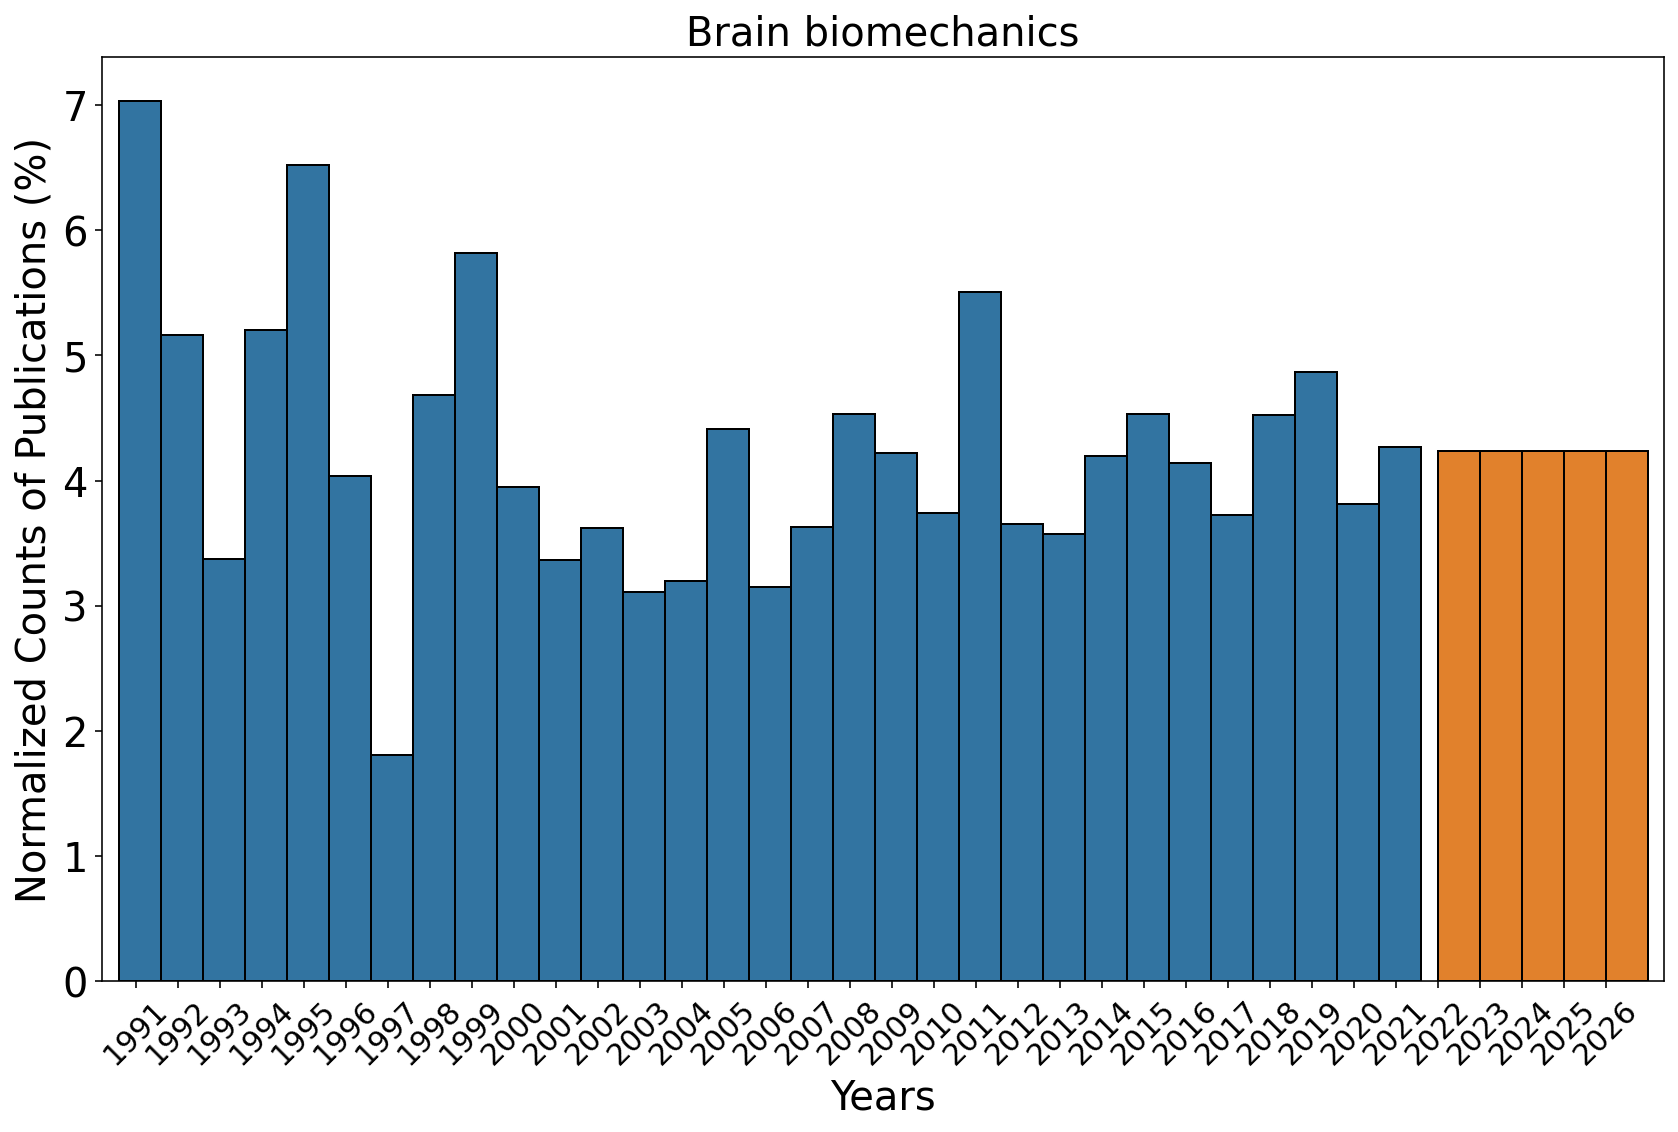

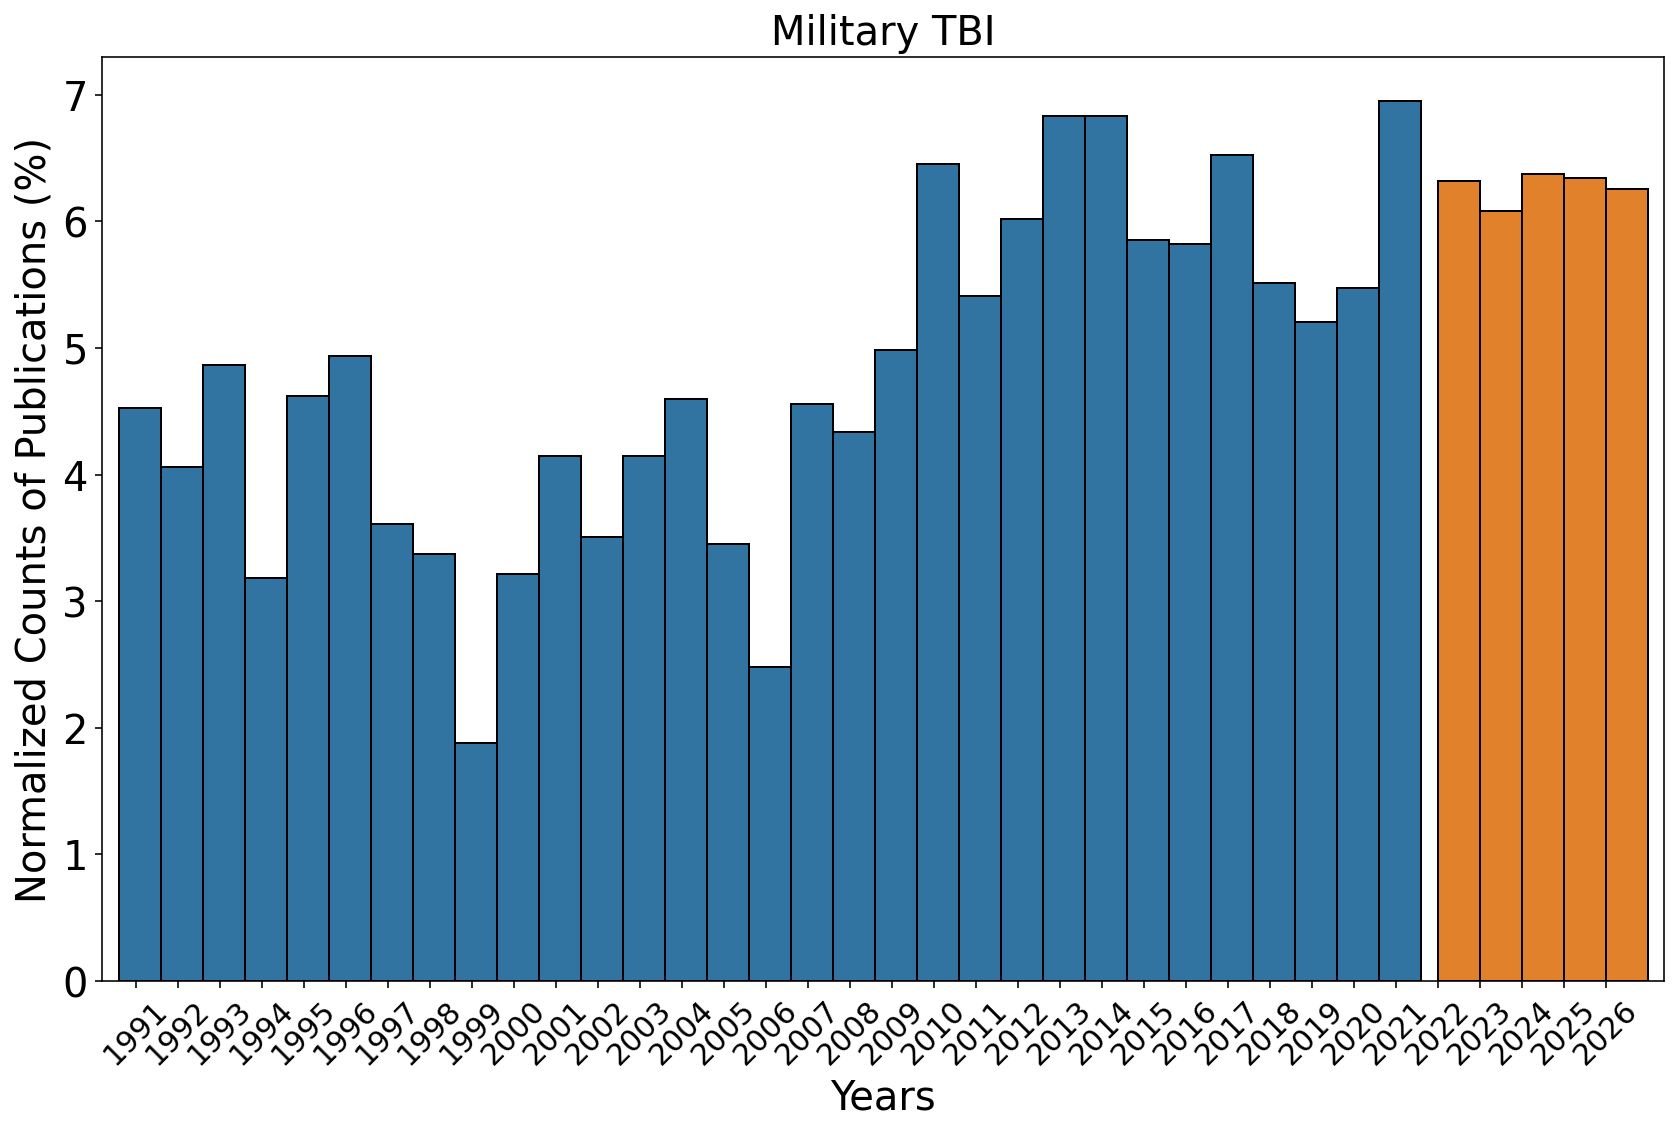

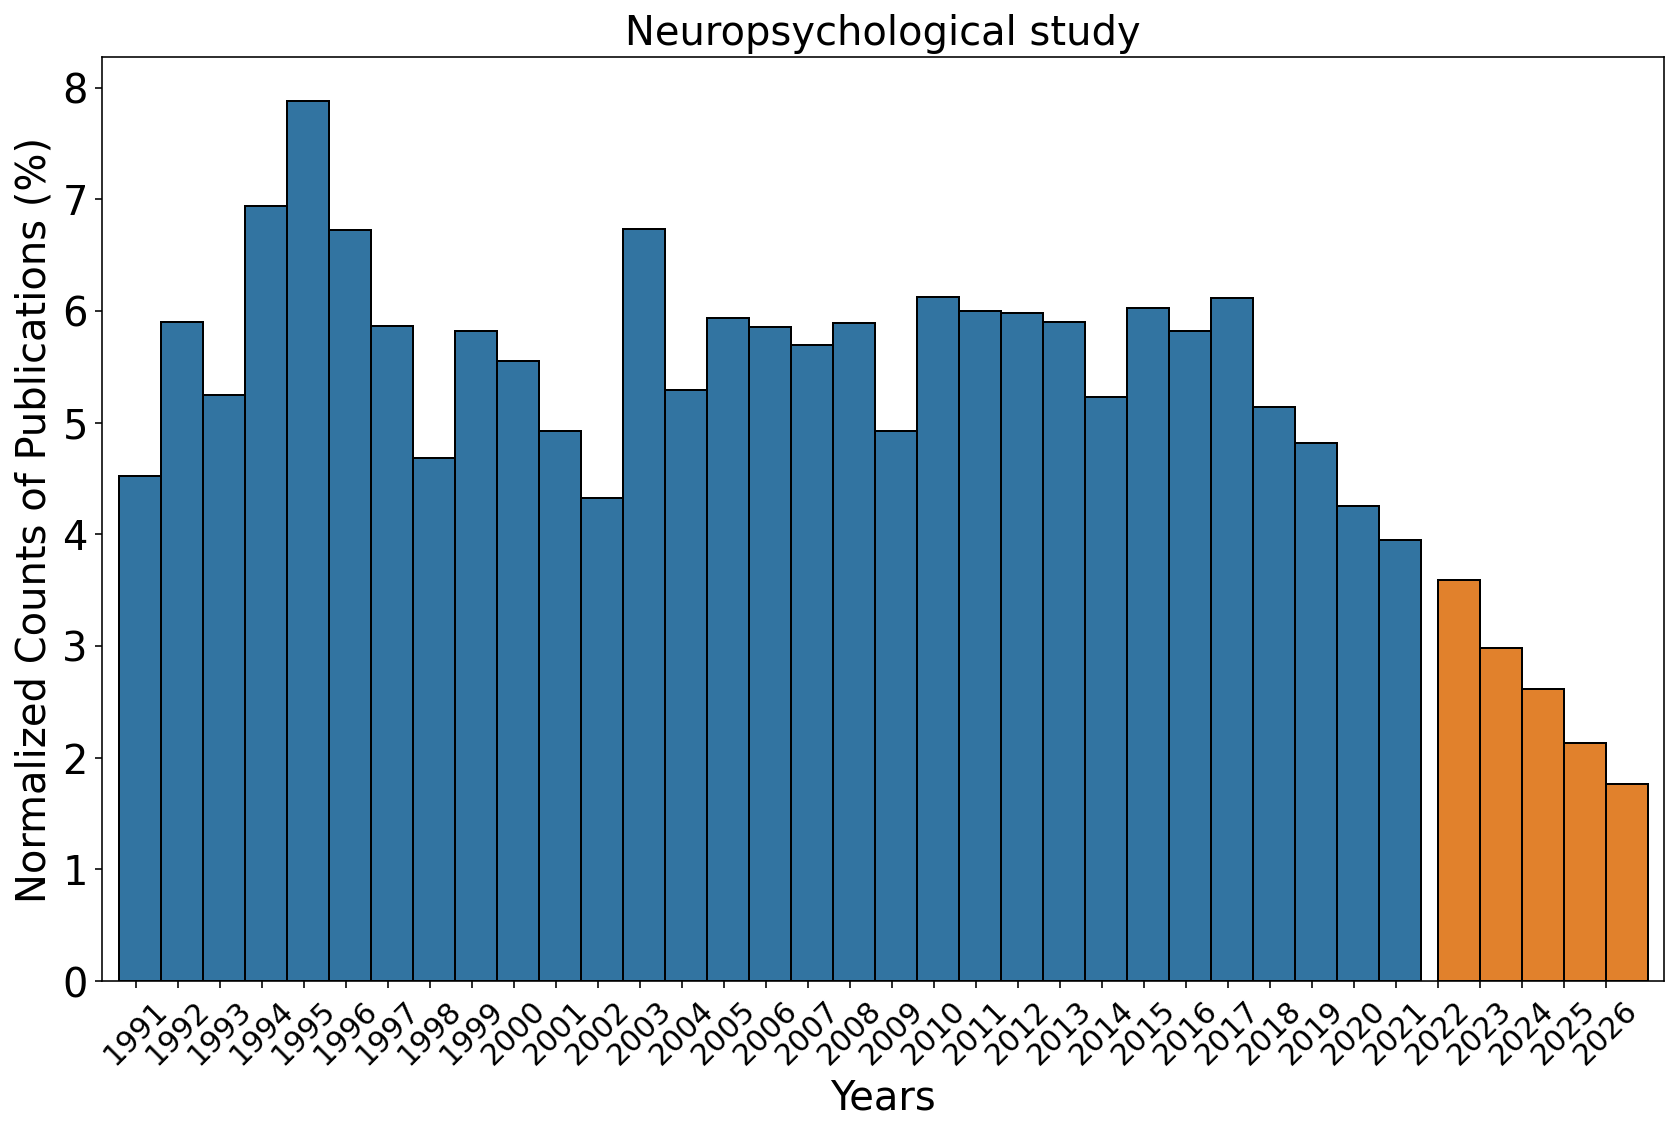

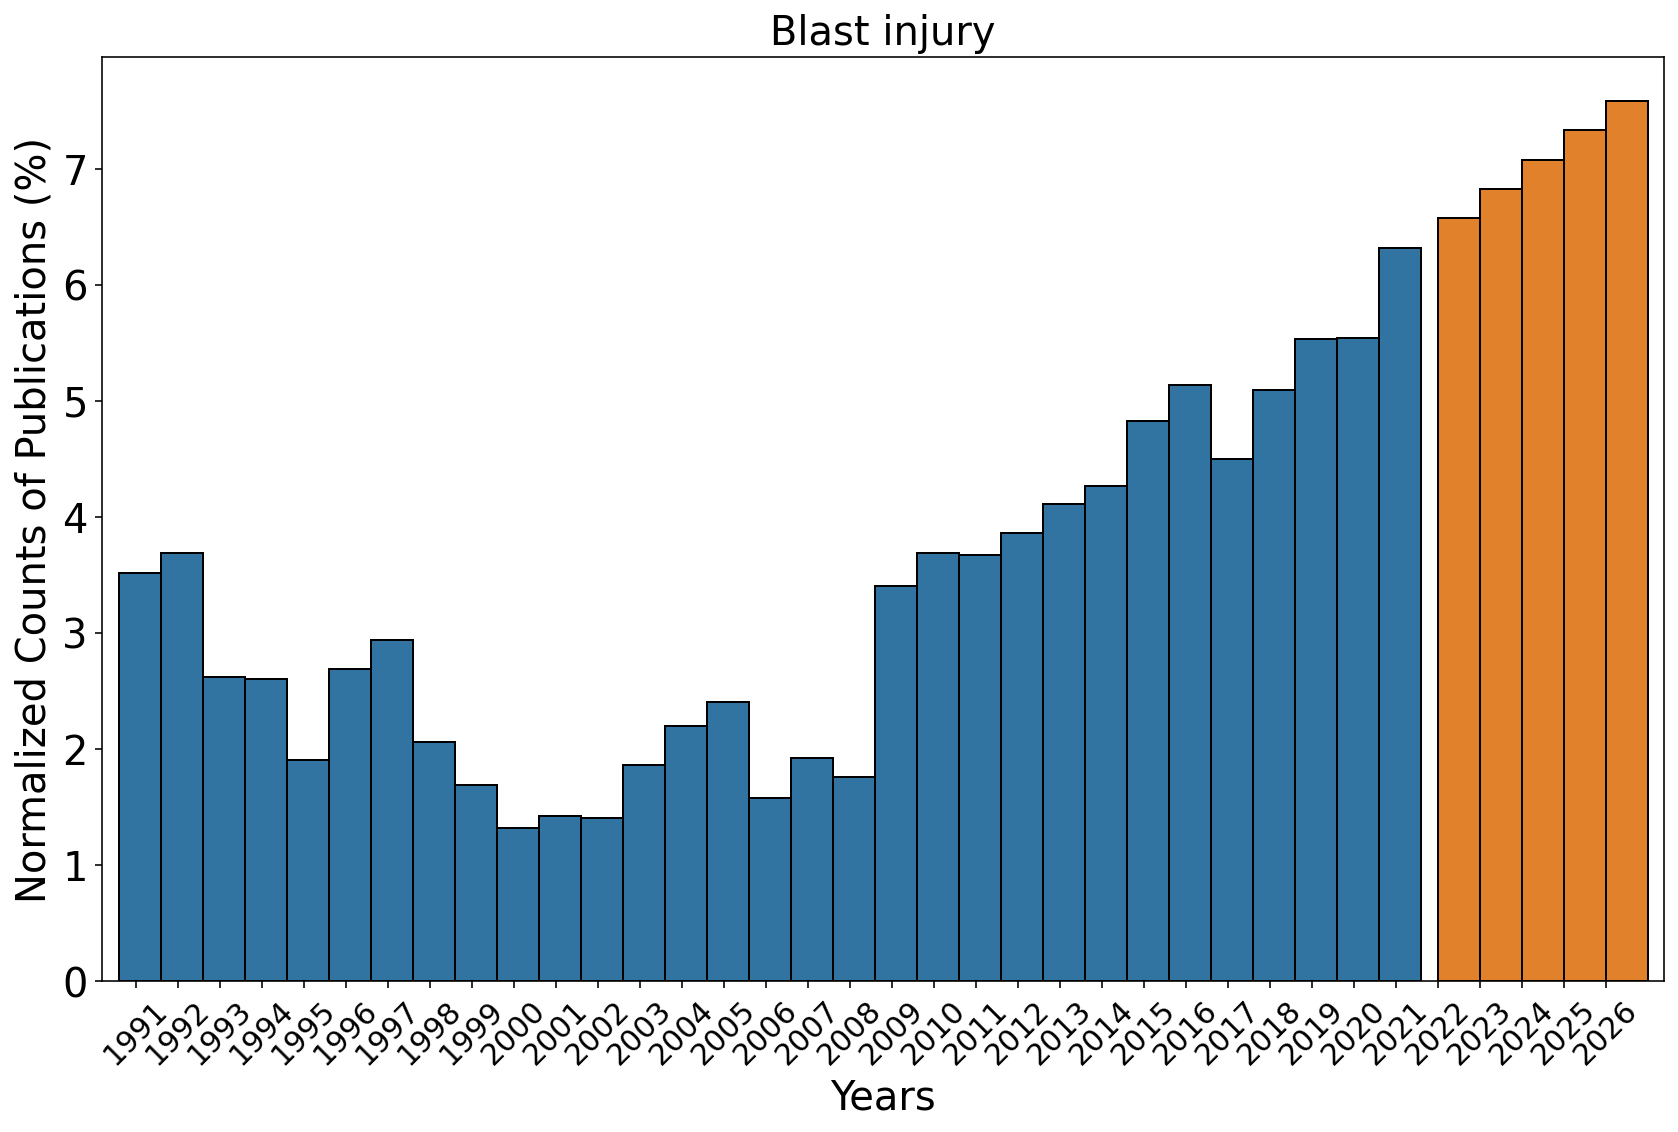

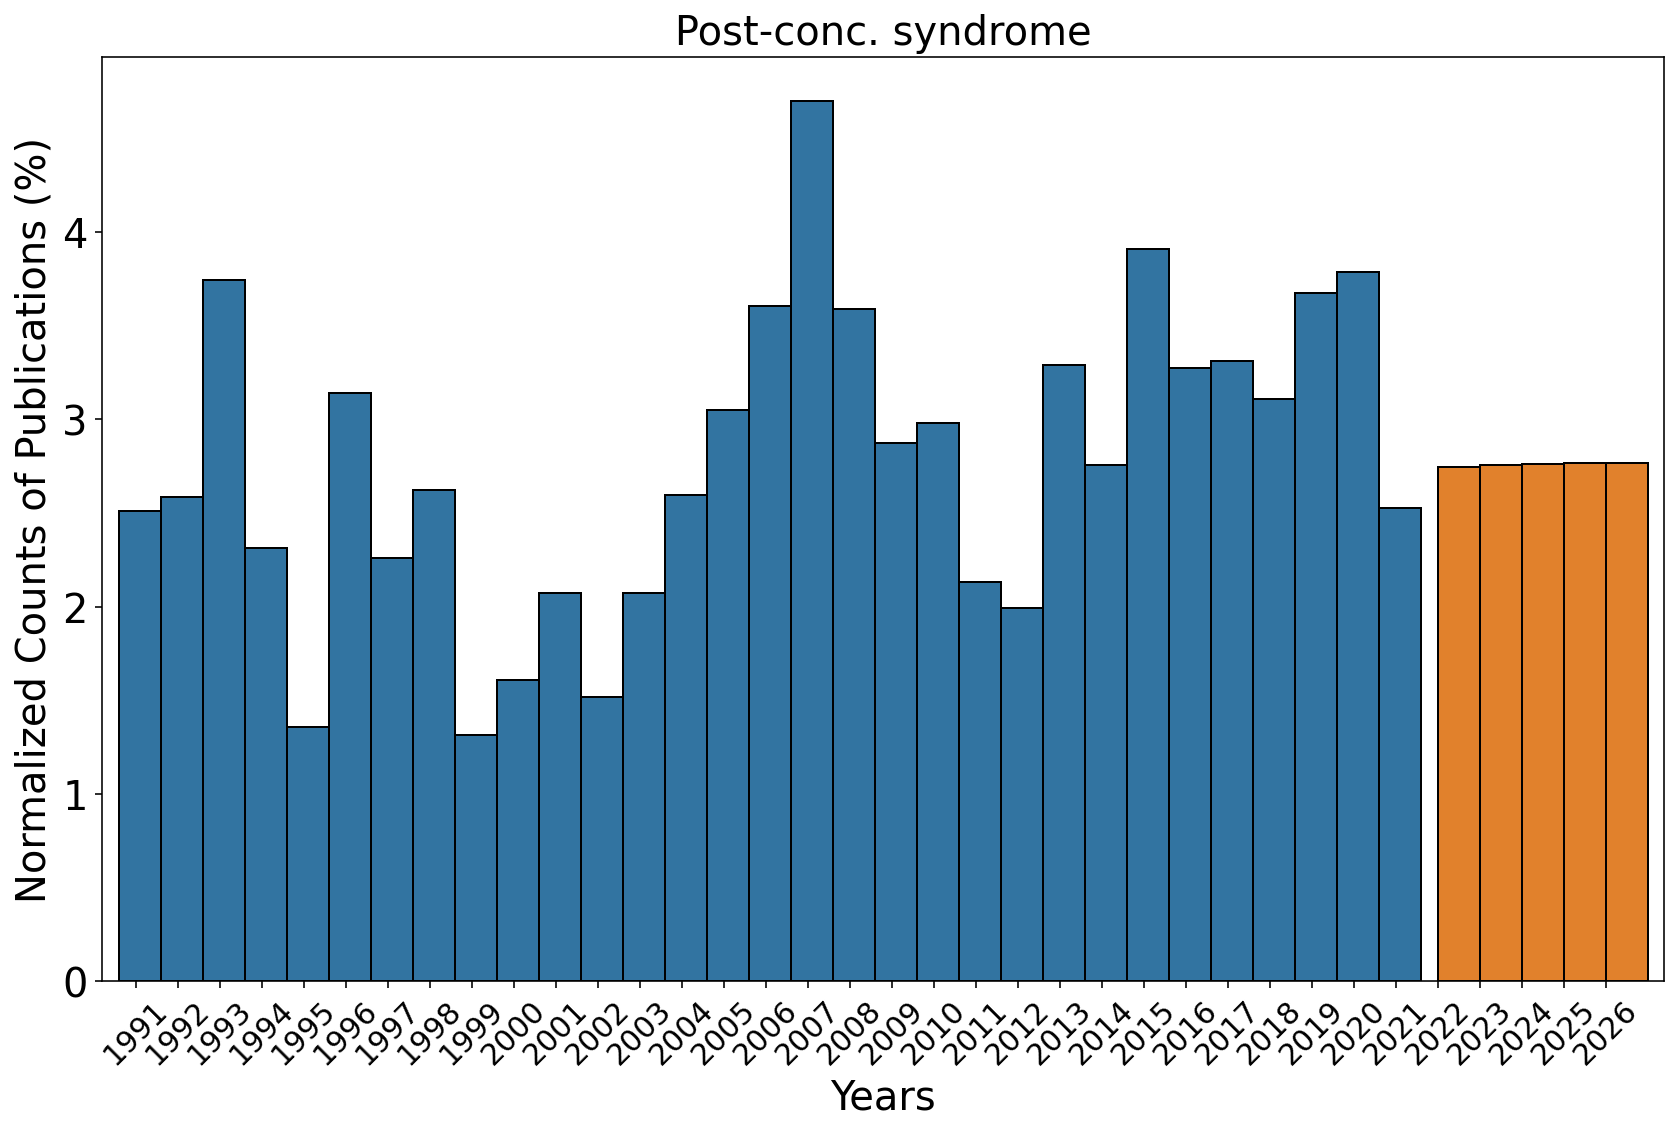

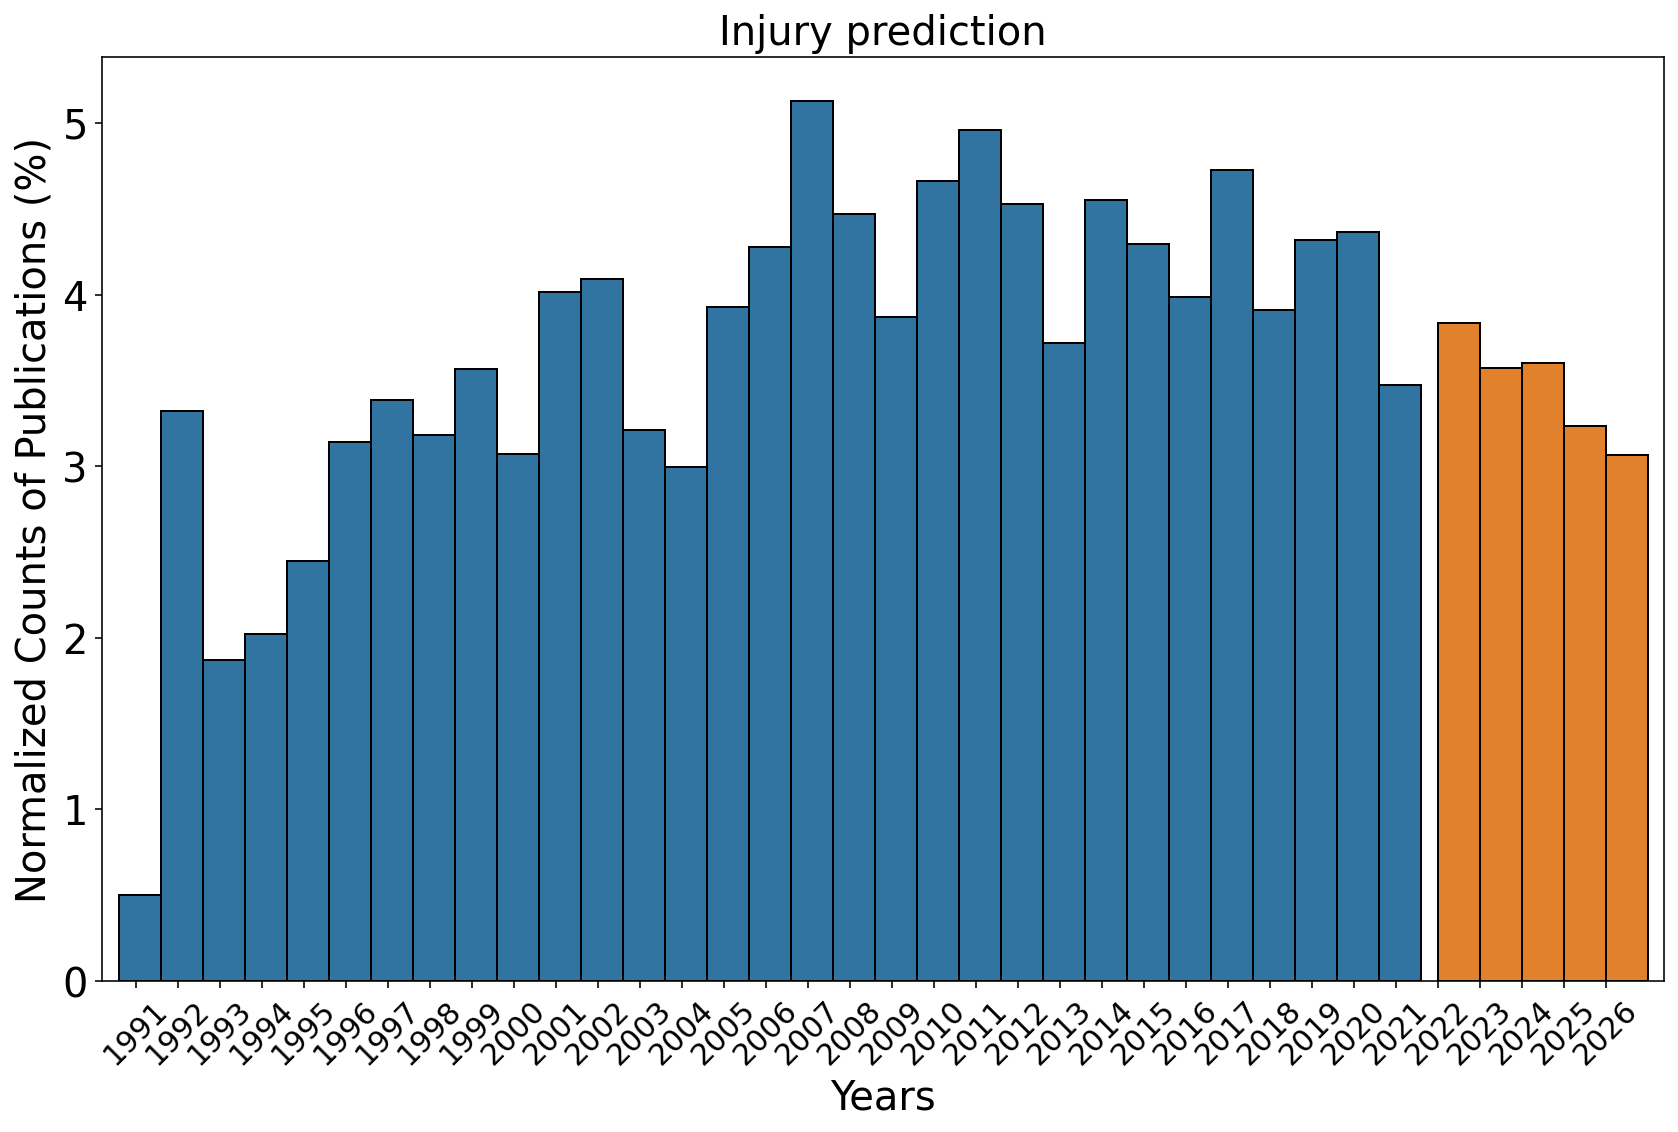

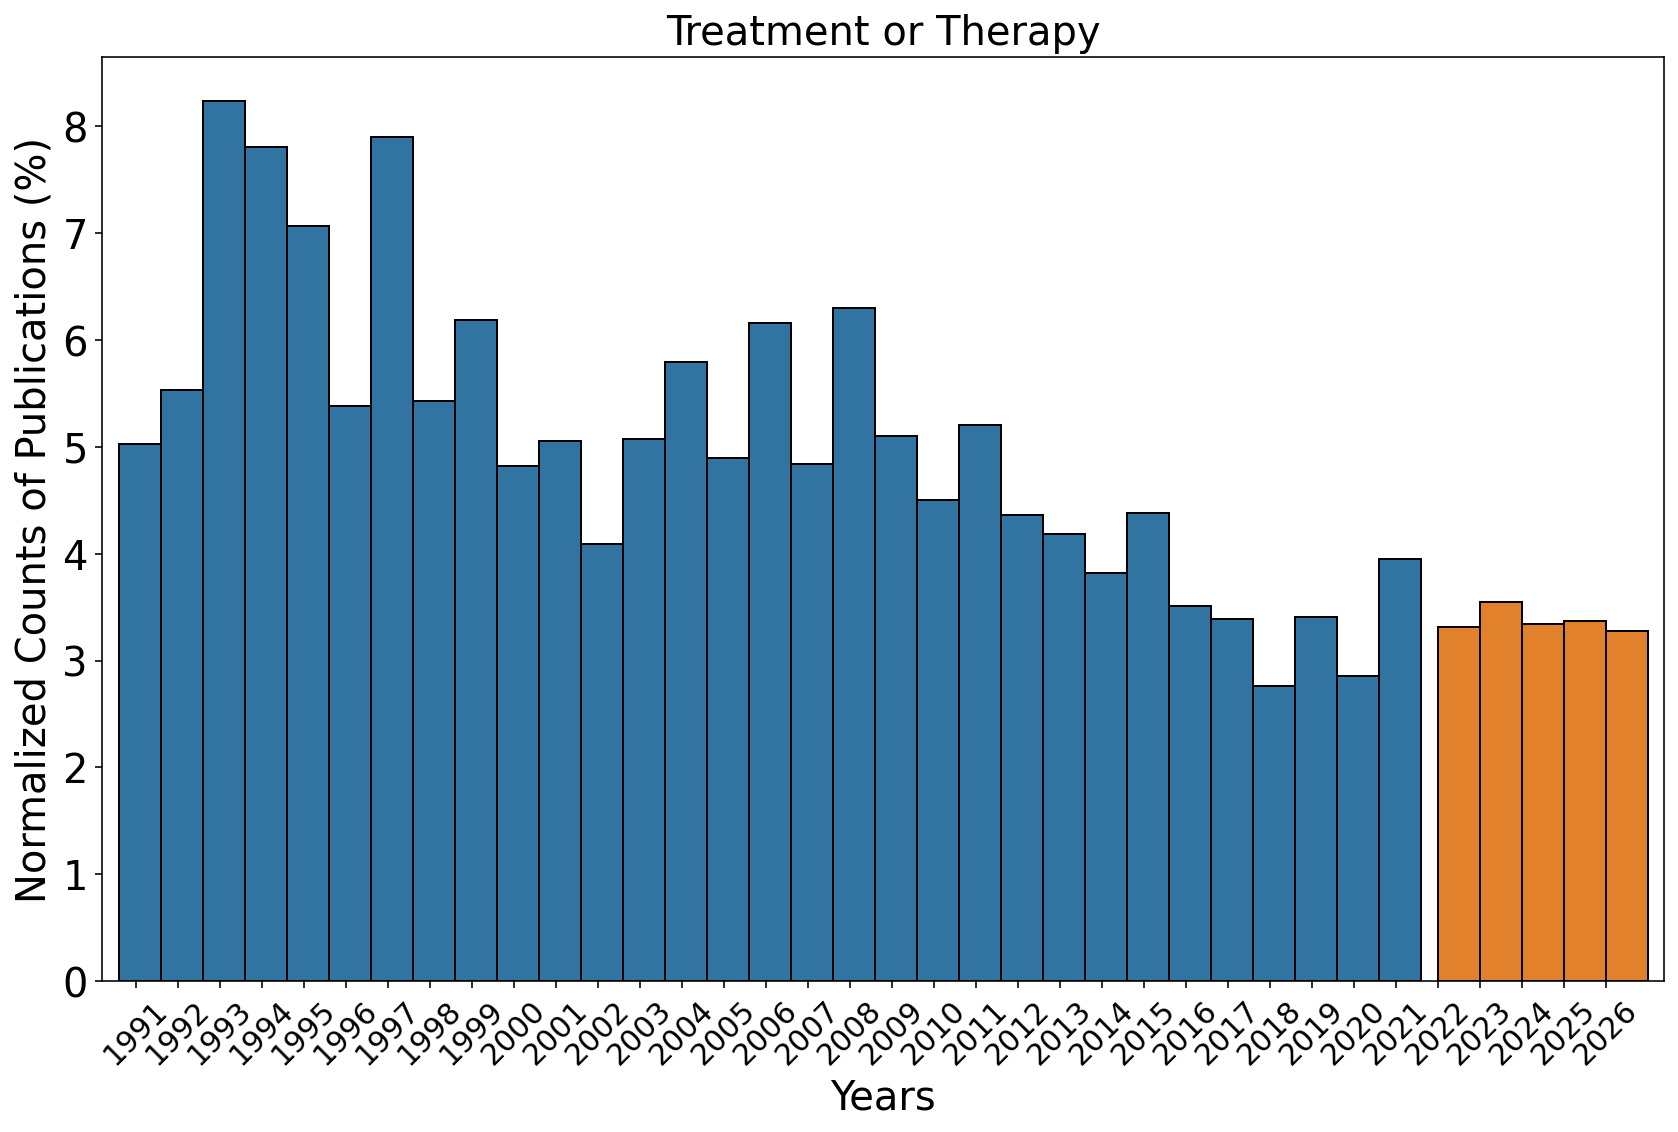

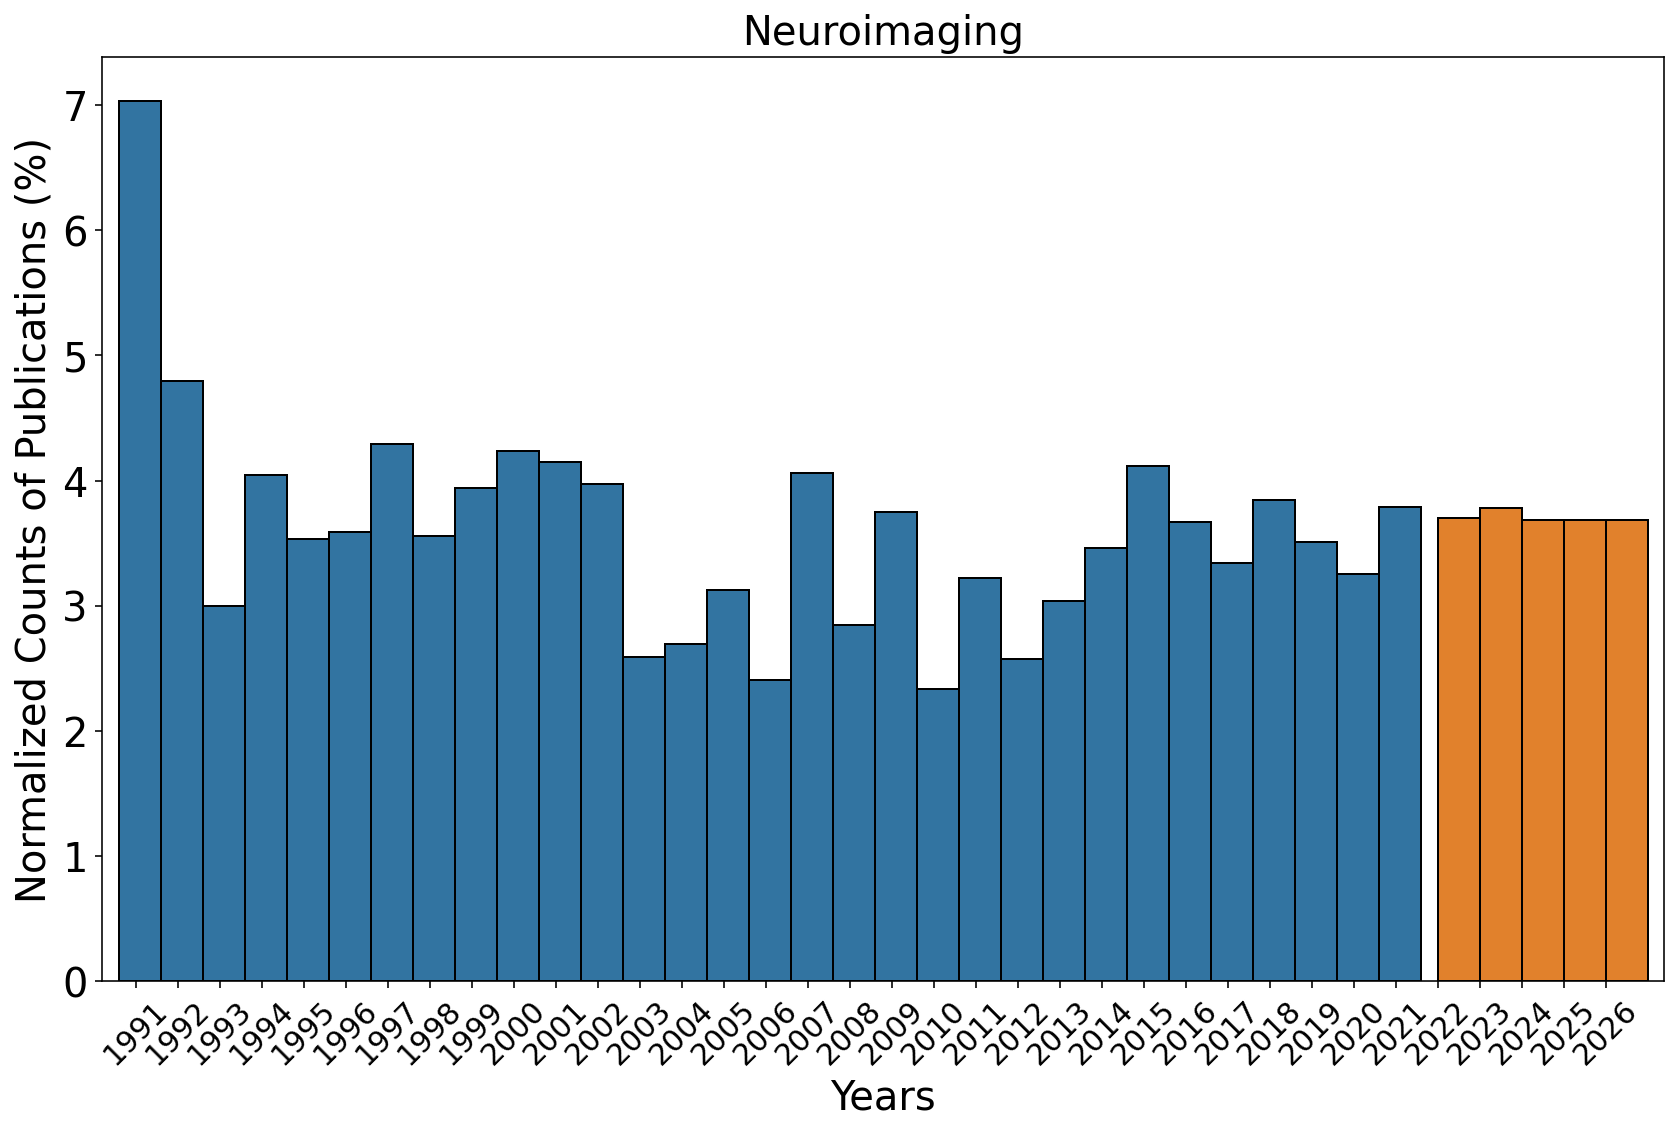

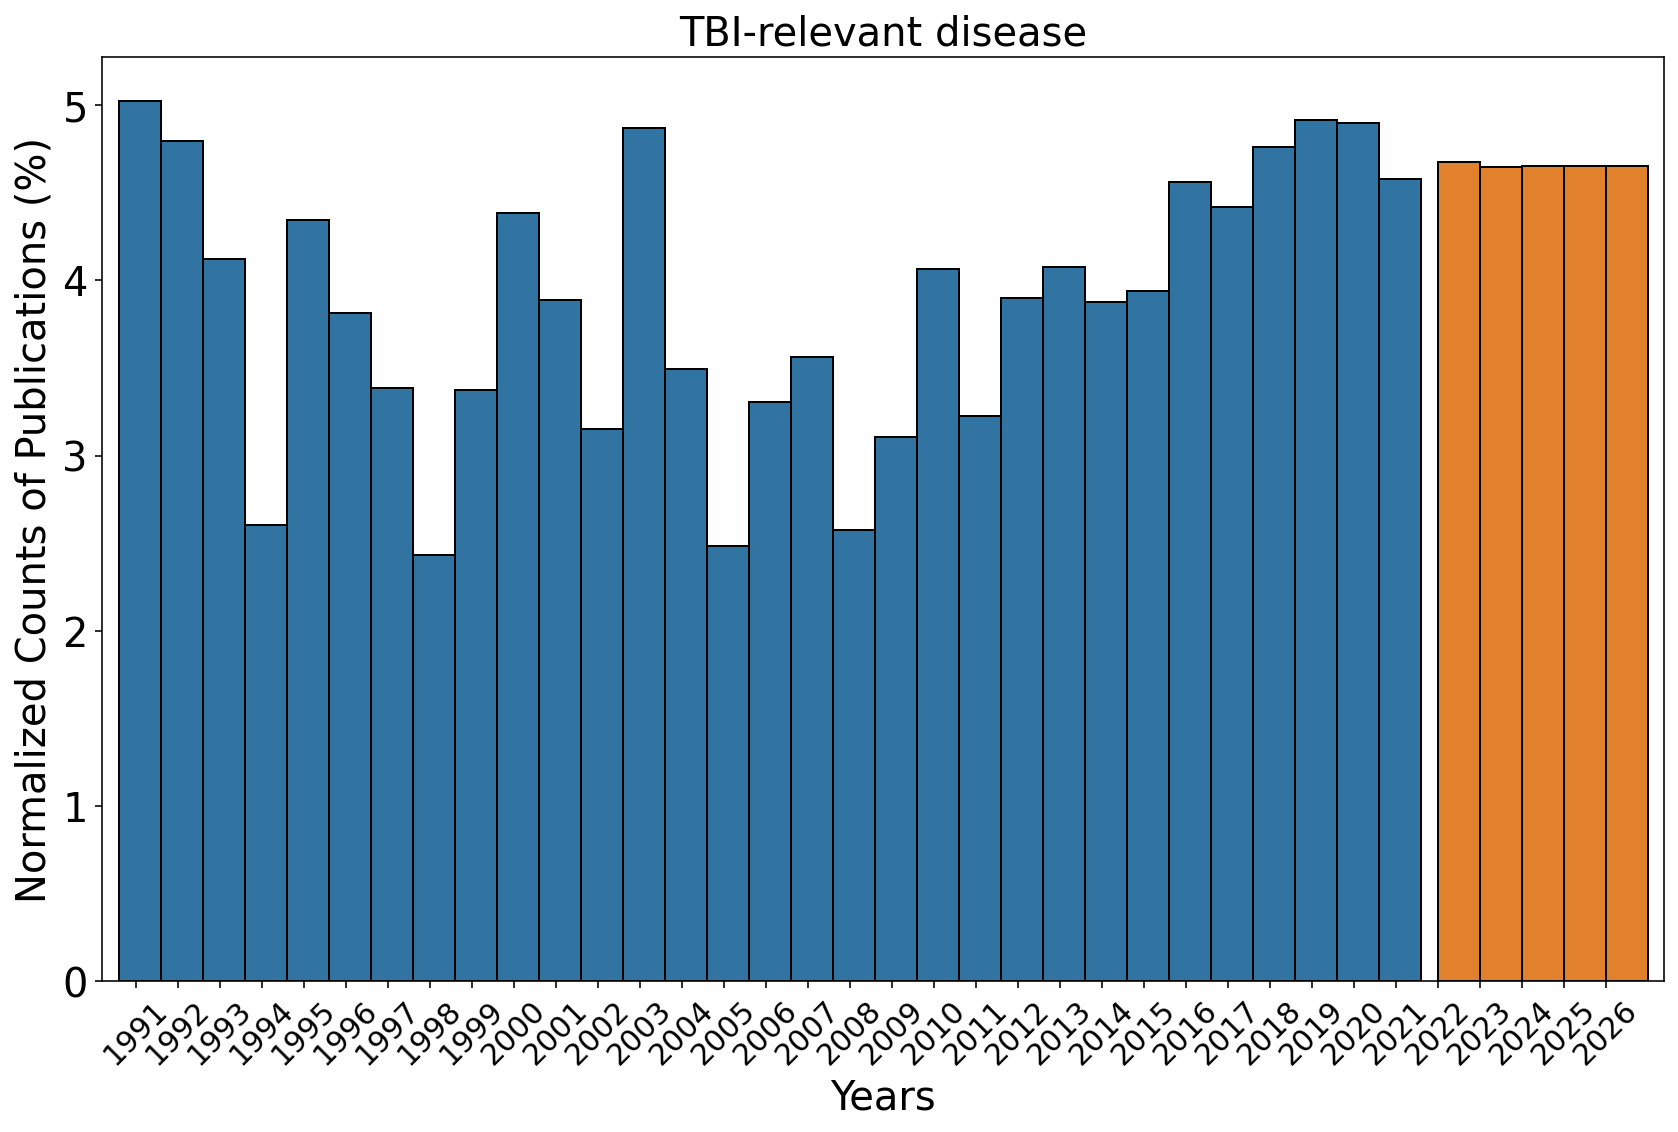

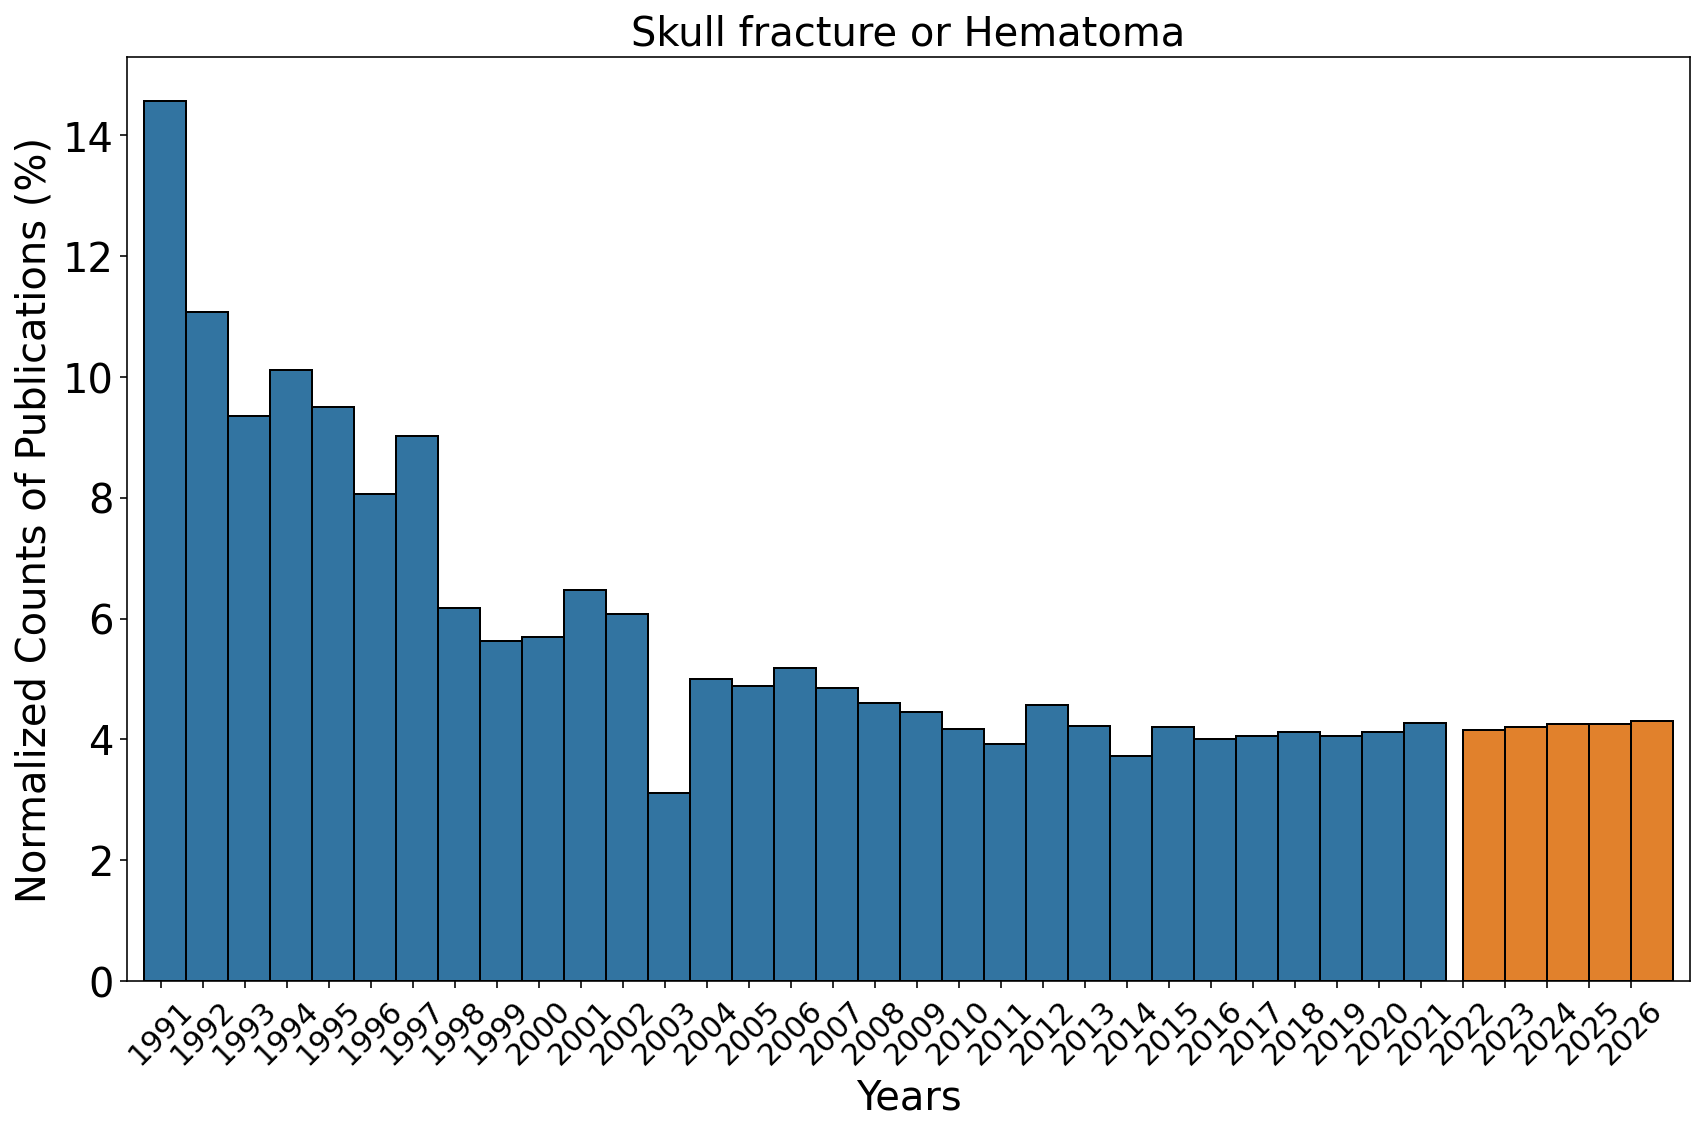

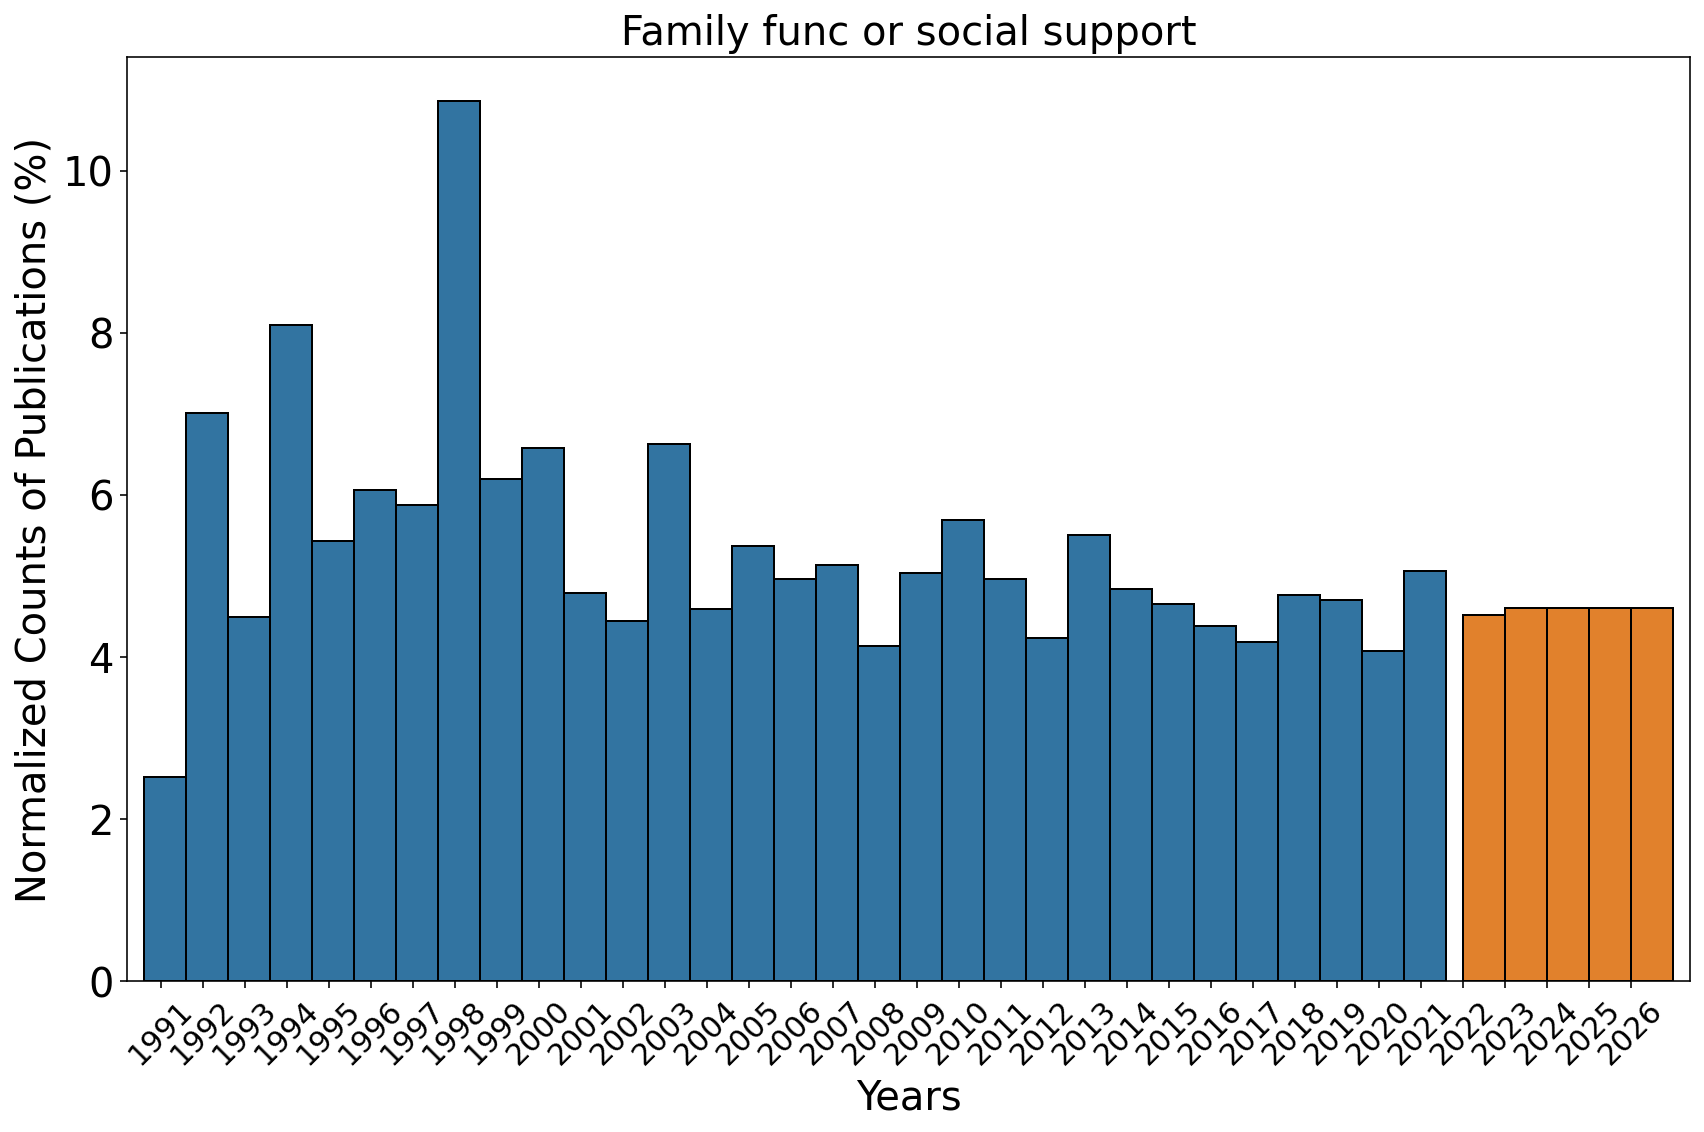

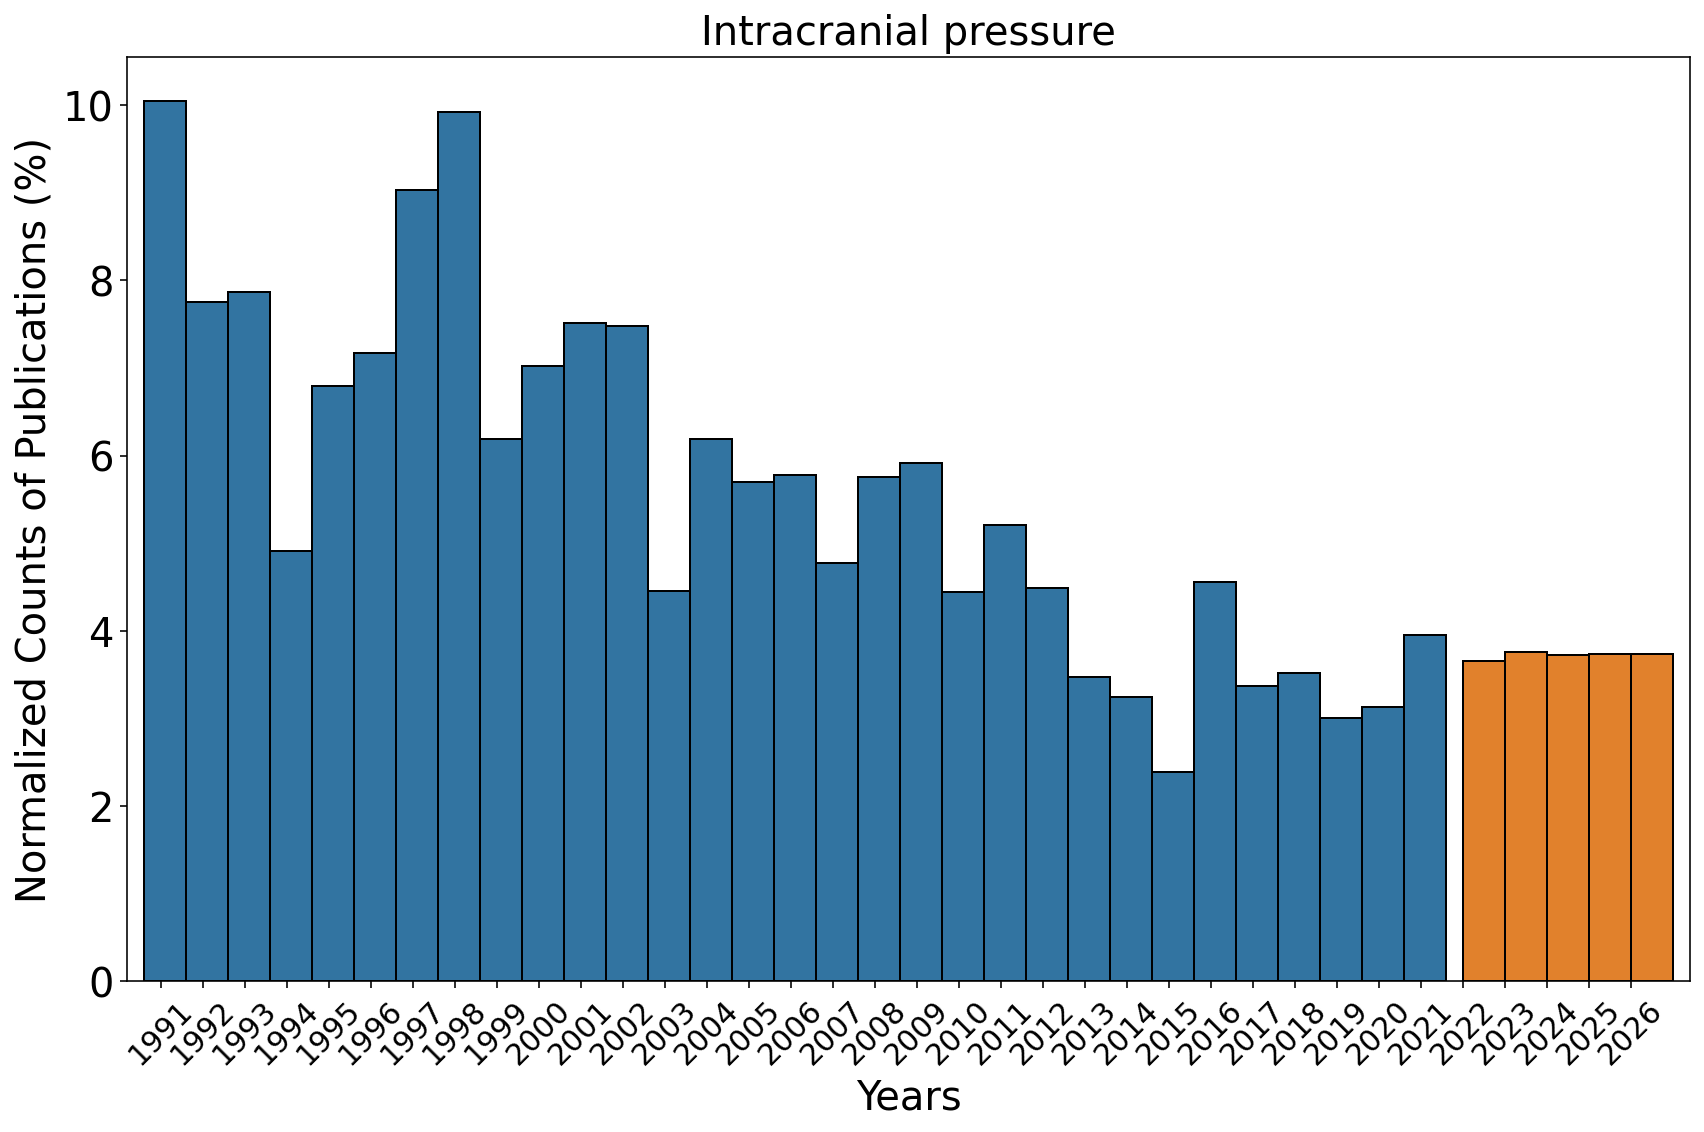

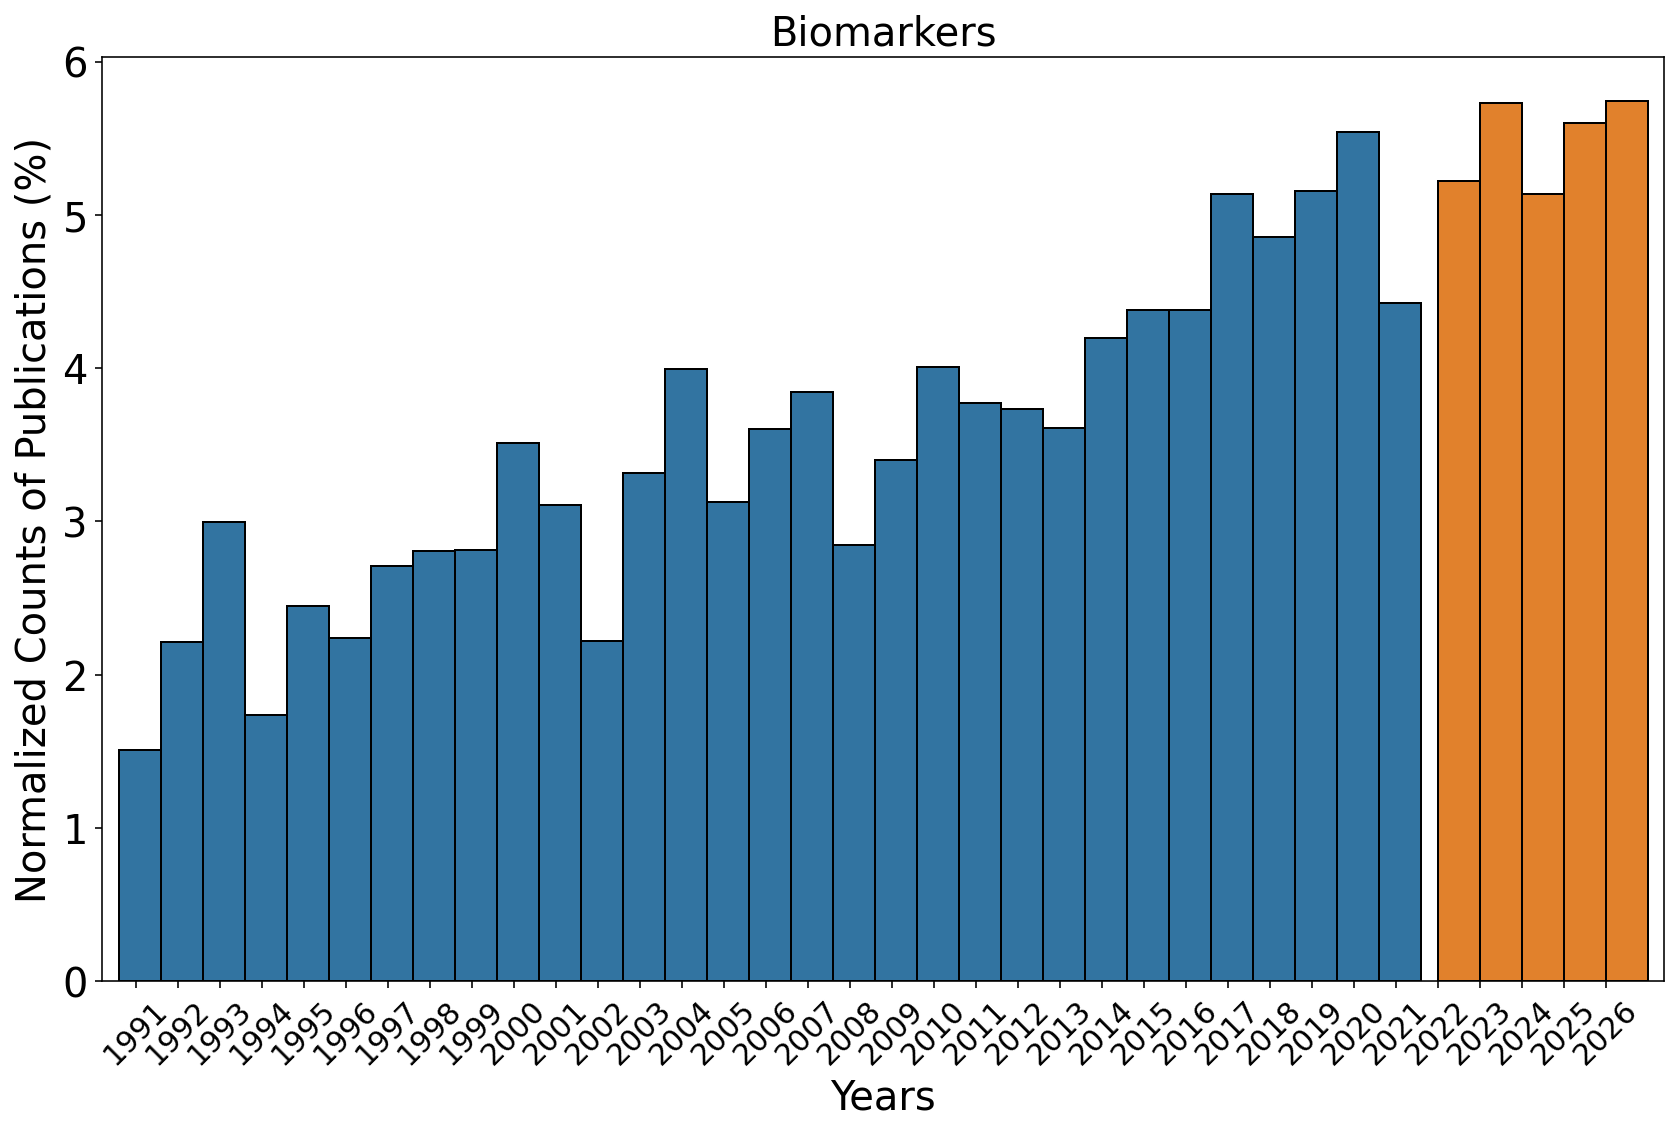

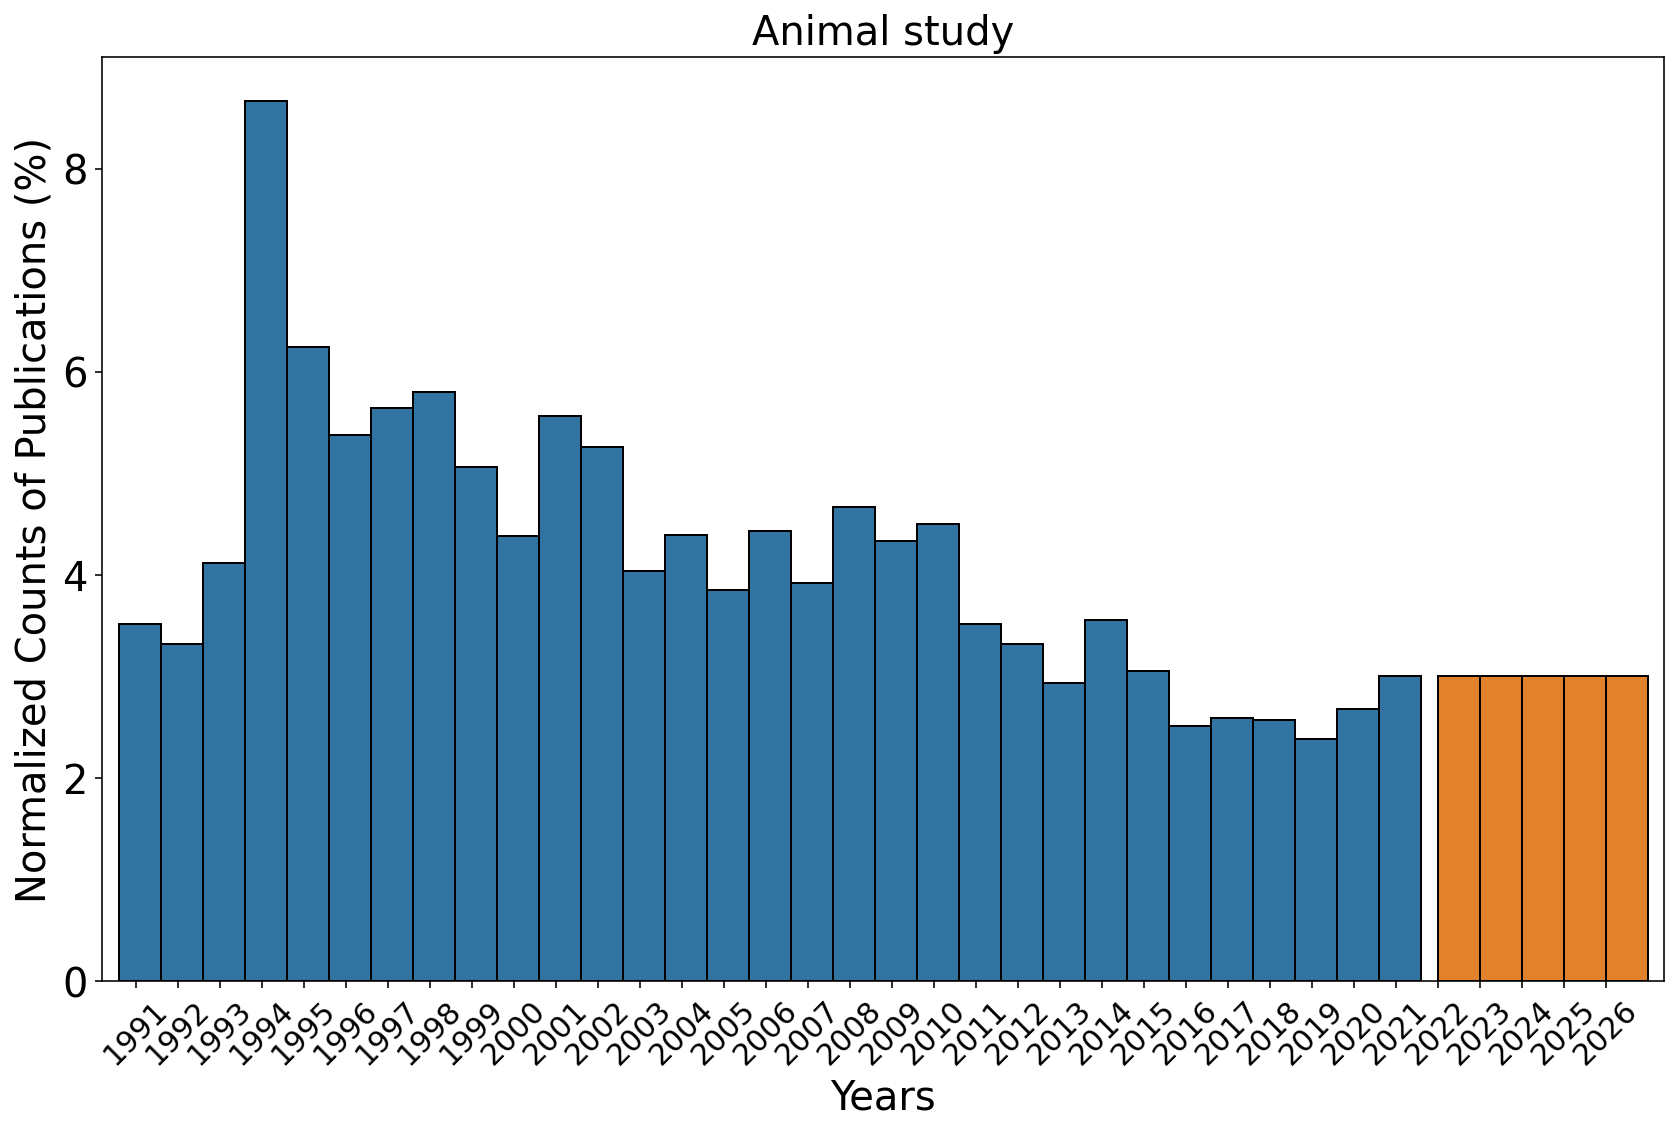

In [24]:
# norm counts
mf = np.zeros([n_topics, forecast_year], )
for n in range(0, n_topics):
    mf[n, :] = forecast_dict[n]
m2 = np.concatenate((m, mf), axis=1) 

years2 = np.arange(1991, 2027)

fontsize=20
fontdict={'fontsize': fontsize}

for n in range(0, n_topics):
   
    t_df = pd.DataFrame({'years': years2, 'norm_counts': m2[n, :]})
    t_df['is_forcast'] = t_df['years'] > 2021

    plt.subplots(figsize=(14, 8.5))
    ax = sns.barplot(x='years',
                     y='norm_counts',
                     data=t_df,
                     hue='is_forcast',
                     edgecolor=(0,0,0),
                    )
    ax.set_xticklabels(list(range(1991, 2027)),
                       rotation=45,
                       fontdict={'fontsize': 15},
                      );
    ax.tick_params(axis="y", labelsize=fontsize)
    ax.set_xlim([-0.8, 36.4])
    
    [t_ax.set_width(1) for t_ax in ax.patches];
    ax.set_xlabel('Years', fontdict=fontdict)
    ax.set_ylabel('Normalized Counts of Publications (%)',
                  fontdict=fontdict);
    
    ax.legend().remove();

    plt.title(topic_name[n], fontdict=fontdict);
    fn = '../figures/{}_development.svg'.format('_'.join(topic_name[n].split(' ')))
    plt.savefig(fn, dpi=300, bbox_inches='tight', facecolor="white")
